<a href="https://colab.research.google.com/github/crownlesslord/temp/blob/main/Parkinsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Download Libraries**

In [ ]:
!pip install deap
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import levy
import shap
from scipy.spatial.distance import euclidean
import xgboost as xgb
from xgboost import XGBClassifier
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import cupy as cp
from cuml.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize, StandardScaler

#**Algorithms Applied**

##**Genetic Algorithm**

In [ ]:
class GeneticFeatureSelector:
    def __init__(self, X, y, n_generations=20, population_size=30, cx_prob=0.8, mut_prob=0.2):
        self.X = X
        self.y = y
        self.n_generations = n_generations
        self.population_size = population_size
        self.cx_prob = cx_prob
        self.mut_prob = mut_prob
        self.toolbox = base.Toolbox()
        self.best_features = None

    def fitness_function(self, individual):
        """Evaluates the fitness of an individual (feature subset)."""
        selected_features = [feature for i, feature in enumerate(self.X.columns) if individual[i] == 1]
        if len(selected_features) == 0:
            return 0,

        X_selected = self.X[selected_features]
        model = xgb.XGBClassifier(tree_method = "hist", device = "cuda", eval_metric="logloss")
        scores = cross_val_score(model, X_selected, self.y, cv=3, scoring="accuracy")
        return scores.mean(),

    def setup_ga(self):
        """Initializes DEAP GA setup."""
        num_features = self.X.shape[1]

        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        self.toolbox.register("attr_bool", random.randint, 0, 1)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual, self.toolbox.attr_bool, num_features)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        self.toolbox.register("evaluate", self.fitness_function)
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def run_ga(self):
        """Executes the Genetic Algorithm."""
        self.setup_ga()
        population = self.toolbox.population(n=self.population_size)

        # Run the algorithm
        best_individuals = algorithms.eaSimple(population, self.toolbox, cxpb=self.cx_prob, mutpb=self.mut_prob,
                                               ngen=self.n_generations, verbose=True)

        best_ind = tools.selBest(population, 1)[0]
        self.best_features = [feature for i, feature in enumerate(self.X.columns) if best_ind[i] == 1]

        return self.best_features

##**Wolf Search Algorithm and Ant Colony Optimization**

In [ ]:
class WolfSearchFeatureSelector:
    def __init__(self, num_wolves=10, max_iter=20):
        self.num_wolves = num_wolves
        self.max_iter = max_iter

    def evaluate(self, X_train, y_train, selected_features):
        if np.sum(selected_features) == 0:
            return 0  # Prevent empty selection

        X_selected = X_train[:, selected_features == 1]

        # Use GPU
        model = XGBClassifier(tree_method="hist", device = "cuda")

        scores = cross_val_score(model, X_selected, y_train, cv=5, scoring="accuracy")
        return scores.mean()

    def optimize(self, X_train, y_train):
        X_train = np.array(X_train)  # Ensure NumPy format
        y_train = np.array(y_train)
        num_features = X_train.shape[1]

        wolves = np.random.randint(0, 2, (self.num_wolves, num_features))
        best_wolf = None
        best_score = -np.inf

        for _ in range(self.max_iter):
            for wolf in wolves:
                score = self.evaluate(X_train, y_train, wolf)
                if score > best_score:
                    best_score = score
                    best_wolf = wolf.copy()

            # Update wolves based on best one
            wolves = np.array([best_wolf if random.random() < 0.5 else np.random.randint(0, 2, num_features)
                               for _ in range(self.num_wolves)])

        selected_feature_indices = np.where(best_wolf == 1)[0]  # Return selected feature indices
        print(f"✅ WSA Selected Features (Indices): {selected_feature_indices.tolist()}")
        return selected_feature_indices

In [ ]:
class AntColonyFeatureSelector:
    def __init__(self, num_ants=10, num_iterations=20, evaporation_rate=0.5):
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.evaporation_rate = evaporation_rate

    def evaluate(self, X_train, y_train, selected_features):
        if np.sum(selected_features) == 0:
            return 0  # Prevent empty selection

        X_selected = X_train[:, selected_features == 1]

        # Use GPU if available, otherwise use CPU
        model = XGBClassifier(tree_method="hist", device = "cuda")

        scores = cross_val_score(model, X_selected, y_train, cv=5, scoring="accuracy")
        return scores.mean()

    def optimize(self, X_train, y_train):
        X_train = np.array(X_train)  # Ensure NumPy format
        y_train = np.array(y_train)
        num_features = X_train.shape[1]
        pheromones = np.ones(num_features)

        best_solution = None
        best_score = -np.inf

        for _ in range(self.num_iterations):
            solutions = []
            scores = []

            for _ in range(self.num_ants):
                ant_solution = np.random.rand(num_features) < pheromones
                score = self.evaluate(X_train, y_train, ant_solution)
                solutions.append(ant_solution)
                scores.append(score)

            best_ant_idx = np.argmax(scores)
            if scores[best_ant_idx] > best_score:
                best_score = scores[best_ant_idx]
                best_solution = solutions[best_ant_idx]

            # Update pheromones
            pheromones = (1 - self.evaporation_rate) * pheromones + best_solution.astype(int)

        selected_feature_indices = np.where(best_solution == 1)[0]  # Return selected feature indices
        print(f"✅ ACO Selected Features (Indices): {selected_feature_indices.tolist()}")
        return selected_feature_indices


##**Grey Wolf Optimizer**

In [ ]:
class GreyWolfOptimizer:
    def __init__(self, n_wolves=10, max_iter=20, n_features=None):
        self.n_wolves = n_wolves
        self.max_iter = max_iter
        self.n_features = n_features

    def _initialize_wolves(self):
        wolves = np.random.randint(0, 2, (self.n_wolves, self.n_features), dtype=np.int32)
        return np.array([self._fix_empty_feature_set(wolf) for wolf in wolves])

    def _fix_empty_feature_set(self, wolf):
        """Ensures at least one feature is always selected."""
        if np.sum(wolf) == 0:
            random_feature = np.random.randint(0, self.n_features)
            wolf[random_feature] = 1
        return wolf

    def _fitness(self, wolf, X_train, y_train, X_val, y_val):
        wolf = self._fix_empty_feature_set(wolf)  # Ensure at least one feature is selected
        selected_features = np.where(wolf == 1)[0]

        if len(selected_features) == 0:
            print("⚠️ ERROR: Selected features are empty. Fixing... ⚠️")
            return 0  # Return worst fitness score (low accuracy)

        X_train_sel = X_train.iloc[:, selected_features]
        X_val_sel = X_val.iloc[:, selected_features]

        if X_train_sel.shape[1] == 0:
            print("🚨 ERROR: X_train_sel is empty despite fixing. 🚨")
            return 0

        num_samples = X_train_sel.shape[0]
        n_bins = max(8, min(256, num_samples // 10))  # Adjust bins dynamically

        model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)
        model.fit(X_train_sel, y_train)
        preds = model.predict(X_val_sel)
        return accuracy_score(y_val, preds)

    def optimize(self, X, y):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
        self.n_features = X_train.shape[1]

        if self.n_features == 0:
            print("🚨 ERROR: No features in dataset! 🚨")
            return []

        wolves = self._initialize_wolves()
        fitness_scores = np.array([self._fitness(w, X_train, y_train, X_val, y_val) for w in wolves])
        sorted_indices = np.argsort(-fitness_scores)

        alpha_wolf, beta_wolf, delta_wolf = wolves[sorted_indices[:3]]

        for _ in range(self.max_iter):
            for i in range(self.n_wolves):
                A1, A2, A3 = np.random.rand(), np.random.rand(), np.random.rand()
                C1, C2, C3 = np.random.rand(), np.random.rand(), np.random.rand()

                D_alpha = np.abs(C1 * alpha_wolf - wolves[i])
                D_beta = np.abs(C2 * beta_wolf - wolves[i])
                D_delta = np.abs(C3 * delta_wolf - wolves[i])

                X1 = alpha_wolf - A1 * D_alpha
                X2 = beta_wolf - A2 * D_beta
                X3 = delta_wolf - A3 * D_delta

                wolves[i] = np.round((X1 + X2 + X3) / 3).astype(np.int32)
                wolves[i] = self._fix_empty_feature_set(wolves[i])

            fitness_scores = np.array([self._fitness(w, X_train, y_train, X_val, y_val) for w in wolves])
            sorted_indices = np.argsort(-fitness_scores)

            alpha_wolf, beta_wolf, delta_wolf = wolves[sorted_indices[:3]]

        best_wolf = self._fix_empty_feature_set(alpha_wolf)  # Final safeguard
        selected_features = np.where(best_wolf == 1)[0]

        if len(selected_features) == 0:
            print("⚠️ ERROR: No features selected at end! Picking one at random. ⚠️")
            selected_features = [np.random.randint(0, self.n_features)]

        return selected_features


# Example Usage:
# Ensure X_train_np, y_train_np are NumPy arrays before passing
# gwo = GreyWolfOptimizer(n_wolves=10, max_iter=20, n_features=X_train_np.shape[1])
# selected_features = gwo.optimize(X_train_np, y_train_np)

##**Swarm of Particles**

In [ ]:
class PSOFeatureSelection:
    def __init__(self, n_particles=30, max_iter=50, inertia_weight=0.7, cognitive=1.5, social=1.5):
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.w = inertia_weight  # Inertia weight
        self.c1 = cognitive  # Cognitive coefficient
        self.c2 = social  # Social coefficient

    def fitness(self, selected_indices, X_train, y_train):
        """Fitness function: Accuracy using cuML RandomForestClassifier with cross-validation."""
        if len(selected_indices) == 0:  # Avoid empty feature sets
            return 0

        # Convert DataFrame to NumPy for efficient slicing
        X_selected = X_train[:, selected_indices]  # NumPy slicing (faster than Pandas .iloc)

        num_samples = X_selected.shape[0]  # Number of training samples
        n_bins = max(8, min(256, num_samples // 10))  # Adjust bins based on dataset size

        model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)

        # Cross-validation accuracy
        scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')
        return scores.mean()

    def optimize(self, X_train, y_train):
        """Run PSO to select the best feature subset."""
        # Convert Pandas DataFrame to NumPy arrays
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()

        n_features = X_train.shape[1]

        # Initialize particles (binary feature selection) and velocities
        particles = np.random.randint(0, 2, (self.n_particles, n_features))  # Binary mask
        velocities = np.random.rand(self.n_particles, n_features) * 0.1  # Small initial velocity

        # Personal and global bests
        pbest_positions = particles.copy()
        pbest_scores = np.array([self.fitness(np.where(p == 1)[0], X_train, y_train) for p in particles])

        gbest_index = np.argmax(pbest_scores)
        gbest_position = pbest_positions[gbest_index]
        gbest_score = pbest_scores[gbest_index]

        for _ in range(self.max_iter):
            for i in range(self.n_particles):
                # Update velocity
                velocities[i] = (
                    self.w * velocities[i] +
                    self.c1 * np.random.rand(n_features) * (pbest_positions[i] - particles[i]) +
                    self.c2 * np.random.rand(n_features) * (gbest_position - particles[i])
                )

                # Apply sigmoid to convert velocity into binary decision
                probabilities = 1 / (1 + np.exp(-velocities[i]))
                particles[i] = (np.random.rand(n_features) < probabilities).astype(int)

                # Evaluate new solution
                selected_indices = np.where(particles[i] == 1)[0]  # Convert mask to feature indices
                score = self.fitness(selected_indices, X_train, y_train)

                # Update personal and global bests
                if score > pbest_scores[i]:
                    pbest_scores[i] = score
                    pbest_positions[i] = particles[i].copy()

                if score > gbest_score:
                    gbest_score = score
                    gbest_position = particles[i].copy()

        return np.where(gbest_position == 1)[0]  # Return selected feature indices

# Example Usage:
# pso = PSOFeatureSelection(n_particles=30, max_iter=50)
# selected_feature_indices = pso.optimize(X_train_df, y_train_df)


##**Cukoo Search Algorithm**

In [ ]:
class CuckooSearchFeatureSelection:
    def __init__(self, n_nests=25, pa=0.25, max_iter=50):
        self.n_nests = n_nests  # Number of nests (solutions)
        self.pa = pa  # Probability of abandoning bad nests
        self.max_iter = max_iter

    def fitness(self, selected_features, X_train, y_train):
        """Fitness function: Accuracy using cuML RandomForestClassifier with cross-validation."""
        if np.sum(selected_features) == 0:  # Avoid empty feature sets
            return 0

        X_selected = X_train[:, selected_features == 1]  # NumPy slicing (efficient)

        num_samples = X_selected.shape[0]  # Number of training samples
        n_bins = max(8, min(256, num_samples // 10))  # Adjust bins based on dataset size

        model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)

        # Cross-validation for fitness evaluation
        scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')
        return scores.mean()

    def levy_flight(self, step_size, dim):
        """Levy flight step update to explore new solutions."""
        return levy.rvs(size=dim) * step_size

    def optimize(self, X_train, y_train):
        """Run Cuckoo Search Algorithm for feature selection."""
        # Convert Pandas DataFrame to NumPy for fast processing
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()

        n_features = X_train.shape[1]

        # Initialize nests (random feature subsets)
        nests = np.random.randint(0, 2, (self.n_nests, n_features))
        fitness_values = np.array([self.fitness(n, X_train, y_train) for n in nests])

        best_nest_index = np.argmax(fitness_values)
        best_nest = nests[best_nest_index]
        best_score = fitness_values[best_nest_index]

        for _ in range(self.max_iter):
            for i in range(self.n_nests):
                # Perform Levy flight to generate a new solution
                step_size = np.random.rand() * 0.1
                new_nest = nests[i] + self.levy_flight(step_size, n_features)
                new_nest = np.where(new_nest > 0.5, 1, 0)  # Convert to binary

                # Ensure at least one feature is selected
                if np.sum(new_nest) == 0:
                    new_nest[np.random.randint(0, n_features)] = 1  # Activate at least one feature

                # Evaluate new solution
                new_fitness = self.fitness(new_nest, X_train, y_train)

                # Replace the nest if it's better
                if new_fitness > fitness_values[i]:
                    nests[i] = new_nest
                    fitness_values[i] = new_fitness

                # Abandon worst nests with probability `pa`
                if np.random.rand() < self.pa:
                    random_nest = np.random.randint(0, 2, n_features)
                    fitness_values[i] = self.fitness(random_nest, X_train, y_train)
                    nests[i] = random_nest

            # Update global best
            best_nest_index = np.argmax(fitness_values)
            best_nest = nests[best_nest_index]
            best_score = fitness_values[best_nest_index]

        return np.where(best_nest == 1)[0]  # Return selected feature indices

# Example Usage:
# csa = CuckooSearchFeatureSelection(n_nests=25, pa=0.25, max_iter=50)
# selected_features = csa.optimize(X_train_np, y_train_np)

##**Harris Hawk's Optimization**

In [ ]:
class HarrisHawksFeatureSelection:
    def __init__(self, population_size=25, max_iter=50):
        self.population_size = population_size  # Number of hawks (solutions)
        self.max_iter = max_iter

    def fitness(self, selected_features, X_train, y_train):
        """Fitness function: Accuracy using cuML RandomForestClassifier with cross-validation."""
        if np.sum(selected_features) == 0:  # Avoid empty feature sets
            return 0

        X_selected = X_train[:, selected_features == 1]  # NumPy slicing (efficient)

        num_samples = X_selected.shape[0]  # Number of training samples
        n_bins = max(8, min(256, num_samples // 10))  # Adjust bins based on dataset size

        model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)

        # Cross-validation for fitness evaluation
        scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')
        return scores.mean()

    def escape_energy(self, iter):
        """Escape energy calculation (decreases over iterations)."""
        return 2 * (1 - iter / self.max_iter)

    def optimize(self, X_train, y_train):
        """Run Harris Hawks Optimization for feature selection."""
        # Convert Pandas DataFrame to NumPy for fast processing
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()

        n_features = X_train.shape[1]

        # Initialize hawks (random feature subsets)
        hawks = np.random.randint(0, 2, (self.population_size, n_features))
        fitness_values = np.array([self.fitness(h, X_train, y_train) for h in hawks])

        best_hawk_index = np.argmax(fitness_values)
        best_hawk = hawks[best_hawk_index]
        best_score = fitness_values[best_hawk_index]

        for iter in range(self.max_iter):
            E = self.escape_energy(iter)  # Escape energy

            for i in range(self.population_size):
                r1, r2 = np.random.rand(), np.random.rand()

                if abs(E) >= 1:  # Exploration phase
                    X_rand = hawks[np.random.randint(0, self.population_size)]
                    new_hawk = X_rand - r1 * abs(X_rand - hawks[i])
                else:  # Exploitation phase (attack strategies)
                    if r2 < 0.5:  # Soft besiege
                        new_hawk = best_hawk - r1 * abs(best_hawk - hawks[i])
                    else:  # Hard besiege
                        new_hawk = best_hawk - r1 * abs(best_hawk - hawks[i]) * E

                # Convert to binary feature selection
                new_hawk = np.where(new_hawk > 0.5, 1, 0)

                # Ensure at least one feature is selected
                if np.sum(new_hawk) == 0:
                    new_hawk[np.random.randint(0, n_features)] = 1  # Activate at least one feature

                # Evaluate new solution
                new_fitness = self.fitness(new_hawk, X_train, y_train)

                # Update hawk if better
                if new_fitness > fitness_values[i]:
                    hawks[i] = new_hawk
                    fitness_values[i] = new_fitness

            # Update global best
            best_hawk_index = np.argmax(fitness_values)
            best_hawk = hawks[best_hawk_index]
            best_score = fitness_values[best_hawk_index]

        return np.where(best_hawk == 1)[0]  # Return selected feature indices

# Example Usage:
# hho = HarrisHawksFeatureSelection(population_size=25, max_iter=50)
# selected_features = hho.optimize(X_train_np, y_train_np)

##**Simulated Annealing**

In [ ]:
class SimulatedAnnealingFeatureSelection:
    def __init__(self, initial_temp=100, cooling_rate=0.95, max_iter=50):
        self.initial_temp = initial_temp  # Initial temperature
        self.cooling_rate = cooling_rate  # Cooling schedule
        self.max_iter = max_iter          # Number of iterations

    def fitness(self, selected_features, X_train, y_train):
        """Evaluate feature subset based on model accuracy."""
        if np.sum(selected_features) == 0:  # Avoid empty feature sets
            return 0
        X_selected = X_train[:, selected_features == 1]

        num_samples = X_selected.shape[0]  # Number of training samples
        n_bins = max(8, min(256, num_samples // 10))  # Adjust bins based on dataset size

        model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)
        scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')
        return scores.mean()

    def neighbor(self, current_solution):
        """Generate a neighboring solution by flipping one feature."""
        neighbor = current_solution.copy()
        flip_index = np.random.randint(len(neighbor))
        neighbor[flip_index] = 1 - neighbor[flip_index]  # Flip feature (0 -> 1 or 1 -> 0)

        # Ensure at least one feature is selected
        if np.sum(neighbor) == 0:
            neighbor[flip_index] = 1

        return neighbor

    def acceptance_probability(self, old_fitness, new_fitness, temperature):
        """Decide whether to accept a worse solution."""
        if new_fitness > old_fitness:
            return 1
        return np.exp((new_fitness - old_fitness) / max(temperature, 1e-8))  # Avoid division by zero

    def optimize(self, X_train, y_train):
        """Perform feature selection using Simulated Annealing."""
        # Convert Pandas DataFrame to NumPy for fast processing
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()

        n_features = X_train.shape[1]

        # Initialize with a random feature subset
        current_solution = np.random.randint(0, 2, n_features)
        current_fitness = self.fitness(current_solution, X_train, y_train)

        best_solution = current_solution.copy()
        best_fitness = current_fitness

        temperature = self.initial_temp

        for _ in range(self.max_iter):
            new_solution = self.neighbor(current_solution)
            new_fitness = self.fitness(new_solution, X_train, y_train)

            if self.acceptance_probability(current_fitness, new_fitness, temperature) > np.random.rand():
                current_solution = new_solution
                current_fitness = new_fitness

            # Update the best solution found
            if new_fitness > best_fitness:
                best_solution = new_solution.copy()
                best_fitness = new_fitness

            # Cool down the temperature
            temperature *= self.cooling_rate

        return np.where(best_solution == 1)[0]  # Return selected feature indices

# Example Usage:
# sa = SimulatedAnnealingFeatureSelection(initial_temp=100, cooling_rate=0.95, max_iter=50)
# selected_features = sa.optimize(X_train_np, y_train_np)

##**WSA + SHAP**

In [ ]:
class WolfSearchFeatureSelection:
    def __init__(self, num_wolves=10, iterations=20):
        self.num_wolves = num_wolves  # Number of wolves (solutions)
        self.iterations = iterations  # Number of iterations

    def fitness(self, selected_features, X_train, y_train):
        """Evaluate feature subset based on model accuracy."""
        if np.sum(selected_features) == 0:  # Prevent empty feature set
            return 0
        X_selected = X_train[:, selected_features == 1]

        num_samples = X_selected.shape[0]  # Number of training samples
        n_bins = max(8, min(256, num_samples // 10))  # Adjust bins based on dataset size

        model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)
        scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')
        return scores.mean()

    def optimize(self, X_train, y_train):
        """Perform feature selection using Wolf Search Algorithm (WSA)."""
        # Convert Pandas DataFrame to NumPy for faster execution
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()

        n_features = X_train.shape[1]

        # Initialize wolves (random feature subsets)
        wolves = np.random.randint(0, 2, (self.num_wolves, n_features))
        fitness_scores = np.array([self.fitness(w, X_train, y_train) for w in wolves])

        best_wolf_idx = np.argmax(fitness_scores)
        best_wolf = wolves[best_wolf_idx].copy()
        best_fitness = fitness_scores[best_wolf_idx]

        for _ in range(self.iterations):
            for i in range(self.num_wolves):
                new_wolf = wolves[i].copy()

                # Flip multiple random bits for better exploration
                flip_indices = np.random.choice(n_features, size=np.random.randint(1, 5), replace=False)
                new_wolf[flip_indices] = 1 - new_wolf[flip_indices]

                # Ensure at least one feature is selected
                if np.sum(new_wolf) == 0:
                    new_wolf[np.random.randint(n_features)] = 1

                new_fitness = self.fitness(new_wolf, X_train, y_train)

                if new_fitness > fitness_scores[i]:
                    wolves[i] = new_wolf
                    fitness_scores[i] = new_fitness

                if new_fitness > best_fitness:
                    best_wolf = new_wolf.copy()
                    best_fitness = new_fitness

        return np.where(best_wolf == 1)[0]  # Return selected feature indices

"""# Apply WSA
wsa = WolfSearchFeatureSelection(num_wolves=10, iterations=20)
selected_features_wsa = wsa.optimize(X_train_np, y_train_np)

# Train model and get SHAP values
X_train_selected = X_train_np[:, selected_features_wsa]
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(X_train_selected, y_train_np)

explainer = shap.Explainer(model, X_train_selected)
shap_values = explainer(X_train_selected)

# SHAP refinement: Keep features with mean absolute SHAP > threshold
shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_threshold = np.median(shap_importance)
final_selected_features = selected_features_wsa[shap_importance > shap_threshold]

print(f"Final Selected Features (WSA + SHAP): {final_selected_features}")"""

'# Apply WSA\nwsa = WolfSearchFeatureSelection(num_wolves=10, iterations=20)\nselected_features_wsa = wsa.optimize(X_train_np, y_train_np)\n\n# Train model and get SHAP values\nX_train_selected = X_train_np[:, selected_features_wsa]\nmodel = RandomForestClassifier(n_estimators=100, max_depth=5)\nmodel.fit(X_train_selected, y_train_np)\n\nexplainer = shap.Explainer(model, X_train_selected)\nshap_values = explainer(X_train_selected)\n\n# SHAP refinement: Keep features with mean absolute SHAP > threshold\nshap_importance = np.abs(shap_values.values).mean(axis=0)\nshap_threshold = np.median(shap_importance)\nfinal_selected_features = selected_features_wsa[shap_importance > shap_threshold]\n\nprint(f"Final Selected Features (WSA + SHAP): {final_selected_features}")'

##**HHO + ACO**

In [ ]:
class HarrisHawksAntColonyFeatureSelection:
    def __init__(self, num_hawks=10, iterations=30, pheromone_decay=0.6):
        self.num_hawks = num_hawks
        self.iterations = iterations
        self.pheromone_decay = pheromone_decay

    def fitness(self, selected_indices, X_train, y_train):
        """Evaluate fitness using cuML RandomForestClassifier with cross-validation."""
        if len(selected_indices) == 0:
            return 0  # Avoid empty feature selection

        X_selected = X_train[:, selected_indices]

        num_samples = X_selected.shape[0]
        n_bins = max(8, min(256, num_samples // 10))  # Adjust bins dynamically

        model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)

        scores = cross_val_score(model, X_selected, y_train, cv=3, scoring='accuracy')
        return scores.mean()

    def optimize(self, X_train, y_train):
        """Perform feature selection using HHO + ACO hybrid optimization."""
        if isinstance(X_train, pd.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.Series):
            y_train = y_train.to_numpy()

        n_features = X_train.shape[1]

        # Initialize random feature selection for hawks
        hawks = [np.random.choice(n_features, size=np.random.randint(1, n_features), replace=False) for _ in range(self.num_hawks)]
        fitness_values = np.array([self.fitness(h, X_train, y_train) for h in hawks])

        best_hawk_index = np.argmax(fitness_values)
        best_hawk = hawks[best_hawk_index]
        best_score = fitness_values[best_hawk_index]

        # 🔹 Harris Hawks Optimization (HHO) Phase
        for _ in range(self.iterations // 2):
            for i in range(self.num_hawks):
                new_hawk = hawks[i].copy()
                flip_index = np.random.randint(n_features)

                # Flip feature selection
                if flip_index in new_hawk:
                    new_hawk = np.delete(new_hawk, np.where(new_hawk == flip_index))
                else:
                    new_hawk = np.append(new_hawk, flip_index)

                # Ensure at least one feature is selected
                if len(new_hawk) == 0:
                    new_hawk = np.append(new_hawk, np.random.randint(n_features))

                new_fitness = self.fitness(new_hawk, X_train, y_train)

                if new_fitness > fitness_values[i]:
                    hawks[i] = new_hawk
                    fitness_values[i] = new_fitness

            # Update best hawk
            best_hawk_index = np.argmax(fitness_values)
            best_hawk = hawks[best_hawk_index]
            best_score = fitness_values[best_hawk_index]

        # 🔹 Ant Colony Optimization (ACO) Phase
        pheromones = np.ones(n_features)
        best_features = best_hawk.copy()

        for _ in range(self.iterations // 2):
            if len(best_features) > 0:
                new_features = np.random.choice(best_features, size=max(1, len(best_features)//2), replace=False)
                pheromones *= self.pheromone_decay  # Decay pheromones
                pheromones[new_features] += 1  # Reinforce selected features

        # Select features based on pheromone levels
        final_selected_features = np.where(pheromones > np.median(pheromones))[0].tolist()

        return final_selected_features  # Return feature indices

# Example Usage:
# hho_aco = HarrisHawksAntColonyFeatureSelection()
# selected_features_hho_aco = hho_aco.optimize(X_train_df, y_train_df)
# print(f"Final Selected Features (HHO + ACO): {selected_features_hho_aco}")


##**Class to Apply all Algorithms**

In [ ]:
class FeatureSelectionEvaluator:
    def __init__(self):
        """
        Initializes feature selection algorithms.
        """
        self.results = {}

        # Initialize all feature selection algorithms
        self.algorithms = {
          "GWO": GreyWolfOptimizer(n_wolves=20, max_iter=30),
          "PSO": PSOFeatureSelection(n_particles=20, max_iter=30),
          "CSA": CuckooSearchFeatureSelection(n_nests=20, pa=0.2, max_iter=30),
          "HHO": HarrisHawksFeatureSelection(population_size=20, max_iter=30),
          "SA": SimulatedAnnealingFeatureSelection(initial_temp=1000, cooling_rate=0.96, max_iter=30),
          "WSA": WolfSearchFeatureSelector(num_wolves=20, max_iter=30),
          "ACO": AntColonyFeatureSelector(num_ants=20, evaporation_rate=0.6, num_iterations=30),
          "HHO+ACO": HarrisHawksAntColonyFeatureSelection(num_hawks=15, iterations=30, pheromone_decay=0.7)
      }

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        """
        Applies feature selection algorithms, trains a model, and evaluates it.
        """
        for name, algorithm in self.algorithms.items():
            print(f"\n🔍 Running {name} Feature Selection...")

            # Perform feature selection
            selected_feature_indices = algorithm.optimize(X_train, y_train)

            # Perform feature selection
            # 🛠 Fix: Convert selected_feature_indices to a list explicitly
            selected_feature_indices = list(selected_feature_indices)

            # 🛠 Fix: Check if no features were selected (avoid empty indexing)
            if len(selected_feature_indices) == 0:
                print(f"⚠️ Warning: {name} selected 0 features! Skipping model training...")
                continue  # Skip this iteration to avoid crashing

            # ✅ Corrected indexing for pandas DataFrame
            X_train_selected = X_train.iloc[:, selected_feature_indices]
            X_test_selected = X_test.iloc[:, selected_feature_indices]

            num_samples = X_train_selected.shape[0]  # Number of training samples
            n_bins = max(8, min(256, num_samples // 10))  # Adjust bins based on dataset size

            # Train a Random Forest classifier
            model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)
            model.fit(X_train_selected, y_train)

            # Make predictions
            y_pred = model.predict(X_test_selected)
            accuracy = accuracy_score(y_test, y_pred)

            # Compute ROC AUC using built-in functions
            y_pred_prob = model.predict_proba(X_test_selected)

            # Ensure NumPy array conversion
            y_test_np = np.array(y_test)  # Convert to NumPy array
            y_pred_prob = np.array(y_pred_prob)  # Convert to NumPy array

            if len(set(y_train)) == 2:  # Binary Classification
                roc_auc = roc_auc_score(y_test_np, y_pred_prob[:, 1])  # No .values needed
                fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob[:, 1])
            else:  # Multi-Class Classification (One-vs-Rest)
                from sklearn.preprocessing import label_binarize

                y_test_bin = label_binarize(y_test_np, classes=np.unique(y_train_np))
                roc_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class="ovr")
                fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())

            # Store results
            self.results[name] = {
                "selected_features": selected_feature_indices,
                "accuracy": accuracy,
                "fpr": fpr,
                "tpr": tpr,
                "roc_auc": roc_auc
            }

            print(f"✅ {name} Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}")

    def plot_results(self):
        """
        Plots the accuracy comparison and ROC curves.
        """
        plt.figure(figsize=(10, 5))
        accuracies = [self.results[algo]["accuracy"] for algo in self.results]
        colors = sns.color_palette("husl", len(self.results))  # Dynamically adjust colors
        plt.bar(self.results.keys(), accuracies, color=colors)
        plt.xlabel("Algorithms")
        plt.ylabel("Accuracy")
        plt.title("Feature Selection Algorithm Comparison")
        plt.xticks(rotation=20)
        plt.show()

        # Plot ROC Curves
        plt.figure(figsize=(8, 6))
        for algo, color in zip(self.results, colors):
            plt.plot(self.results[algo]["fpr"], self.results[algo]["tpr"], color=color,
                     label=f'{algo} (AUC = {self.results[algo]["roc_auc"]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve Comparison")
        plt.legend(loc="lower right")
        plt.show()

"""# Load and preprocess dataset
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

# Run evaluator
evaluator = FeatureSelectionEvaluator()
evaluator.train_and_evaluate(X_train_df, y_train_df, X_test_df, y_test_df)

# Plot results
evaluator.plot_results()"""


'# Load and preprocess dataset\nX_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)\n\n# Run evaluator\nevaluator = FeatureSelectionEvaluator()\nevaluator.train_and_evaluate(X_train_df, y_train_df, X_test_df, y_test_df)\n\n# Plot results\nevaluator.plot_results()'

In [ ]:
import gc
import tensorflow as tf
class FeatureSelectionEvaluator:
    def __init__(self):
        """
        Initializes feature selection algorithms.
        """
        self.results = {}

        # Initialize all feature selection algorithms
        self.algorithms = {
            "GWO": GreyWolfOptimizer(n_wolves=20, max_iter=30),
            "PSO": PSOFeatureSelection(n_particles=20, max_iter=30),
            "CSA": CuckooSearchFeatureSelection(n_nests=20, pa=0.2, max_iter=30),
            "HHO": HarrisHawksFeatureSelection(population_size=20, max_iter=30),
            "SA": SimulatedAnnealingFeatureSelection(initial_temp=1000, cooling_rate=0.96, max_iter=30),
            "WSA": WolfSearchFeatureSelector(num_wolves=20, max_iter=30),
            "ACO": AntColonyFeatureSelector(num_ants=20, evaporation_rate=0.5, num_iterations=30),
            "HHO+ACO": HarrisHawksAntColonyFeatureSelection(num_hawks=15, iterations=30, pheromone_decay=0.7)
        }

    def clear_memory(self):
        """
        Clears memory to prevent memory leaks (Garbage collection).
        """
        # Force garbage collection
        del self.results  # Delete results if not needed anymore
        gc.collect()  # Force garbage collection
        tf.keras.backend.clear_session()  # Clear TensorFlow session if used

        # If using PyTorch, you can clear GPU memory with torch.cuda.empty_cache()

        print("Memory cleared")

    def train_and_evaluate(self, X_train, y_train, X_test, y_test):
        """
        Applies feature selection algorithms, trains a model, and evaluates it.
        """
        for name, algorithm in self.algorithms.items():
            print(f"\n🔍 Running {name} Feature Selection...")

            # Perform feature selection
            selected_feature_indices = algorithm.optimize(X_train, y_train)

            # Convert selected_feature_indices to a list explicitly
            selected_feature_indices = list(selected_feature_indices)

            # Check if no features were selected (avoid empty indexing)
            if len(selected_feature_indices) == 0:
                print(f"⚠️ Warning: {name} selected 0 features! Skipping model training...")
                continue  # Skip this iteration to avoid crashing

            # Corrected indexing for pandas DataFrame
            X_train_selected = X_train.iloc[:, selected_feature_indices]
            X_test_selected = X_test.iloc[:, selected_feature_indices]

            # Train a Random Forest classifier
            model = RandomForestClassifier(n_estimators=100, max_depth=50)
            model.fit(X_train_selected, y_train)

            # Make predictions
            y_pred = model.predict(X_test_selected)
            accuracy = accuracy_score(y_test, y_pred)

            # Compute ROC AUC using built-in functions
            y_pred_prob = model.predict_proba(X_test_selected)

            # Ensure NumPy array conversion
            y_test_np = np.array(y_test)  # Convert to NumPy array
            y_pred_prob = np.array(y_pred_prob)  # Convert to NumPy array

            if len(set(y_train)) == 2:  # Binary Classification
                roc_auc = roc_auc_score(y_test_np, y_pred_prob[:, 1])
                fpr, tpr, _ = roc_curve(y_test_np, y_pred_prob[:, 1])
            else:  # Multi-Class Classification (One-vs-Rest)
                y_test_bin = label_binarize(y_test_np, classes=np.unique(y_train))
                roc_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class="ovr")
                fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())

            # Store results
            self.results[name] = {
                "selected_features": selected_feature_indices,
                "accuracy": accuracy,
                "fpr": fpr,
                "tpr": tpr,
                "roc_auc": roc_auc
            }

            print(f"✅ {name} Accuracy: {accuracy:.4f}, AUC: {roc_auc:.4f}")

            # Clear memory after each algorithm run to avoid OOM
            self.clear_memory()

    def plot_results(self):
        """
        Plots the accuracy comparison and smoothed ROC curves.
        """
        # Plot accuracy comparison
        plt.figure(figsize=(10, 5))
        accuracies = [self.results[algo]["accuracy"] for algo in self.results]
        colors = sns.color_palette("husl", len(self.results))  # Dynamically adjust colors
        plt.bar(self.results.keys(), accuracies, color=colors)
        plt.xlabel("Algorithms")
        plt.ylabel("Accuracy")
        plt.title("Feature Selection Algorithm Comparison")
        plt.xticks(rotation=20)
        plt.show()

        # Plot smoothed ROC Curves
        plt.figure(figsize=(8, 6))
        for algo, color in zip(self.results, colors):
            fpr = self.results[algo]["fpr"]
            tpr = self.results[algo]["tpr"]

            # Interpolation for smoother ROC curve
            fpr_smooth = np.linspace(0, 1, 100)  # More points for smoothness
            tpr_smooth = np.interp(fpr_smooth, fpr, tpr)  # Interpolate TPR values

            plt.plot(fpr_smooth, tpr_smooth, color=color,
                     label=f'{algo} (AUC = {self.results[algo]["roc_auc"]:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Smoothed ROC Curve Comparison")
        plt.legend(loc="lower right")
        plt.show()

# Example of how to run the evaluation
# Load and preprocess dataset
# X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)

# evaluator = FeatureSelectionEvaluator()
# evaluator.train_and_evaluate(X_train_df, y_train_df, X_test_df, y_test_df)
# evaluator.plot_results()


#**Dataset 1 - UCI [0, 1]**

In [ ]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
data = pd.read_csv(url)

# Check the data structure
print(data.head())


             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ...   

   Shimmer:DDA      NHR     HNR  status      RPDE       DFA   spread1  \
0      0.0654

In [ ]:
# Drop the 'name' column
data.drop(columns=['name'], inplace=True)

# Separate features and target
X = data.drop(columns=['status'])
y = data['status']

# Convert X (features) to float32
X = X.astype('float32')  # or use 'float64' if you prefer maximum precision
# Convert y (labels) to int
y = y.astype('int8')    # or 'int8' to save memory if labels are only 0/1

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get feature names
feature_names = X.columns.tolist()


🔍 Running GWO Feature Selection...
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
✅ GWO Accuracy: 0.9231, AUC: 0.9129

🔍 Running PSO Feature Selection...
✅ PSO Accuracy: 0.8974, AUC: 0.9487

🔍 Running CSA Feature Selection...
✅ CSA Accuracy: 0.9231, AUC: 0.9152

🔍 Running HHO Feature Selection...
✅ HHO Accuracy: 0.9487, AUC: 0.9152

🔍 Running SA Feature Selection...
✅ SA Accuracy: 0.9231, AUC: 0.9554

🔍 Running WSA Feature Selection...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:58:12] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


✅ WSA Selected Features (Indices): [0, 1, 3, 4, 5, 7, 8, 10, 13, 16, 18, 19, 20, 21]
✅ WSA Accuracy: 0.9487, AUC: 0.9174

🔍 Running ACO Feature Selection...
✅ ACO Selected Features (Indices): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
✅ ACO Accuracy: 0.9487, AUC: 0.9241

🔍 Running HHO+ACO Feature Selection...
✅ HHO+ACO Accuracy: 0.8718, AUC: 0.9107


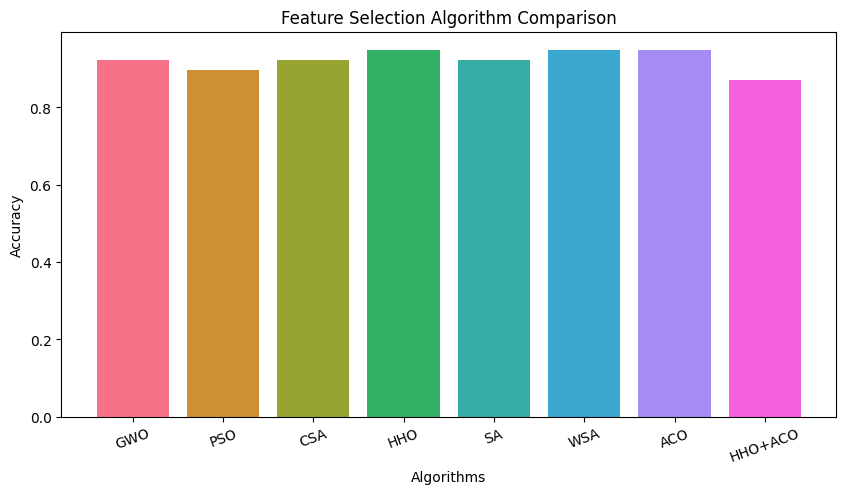

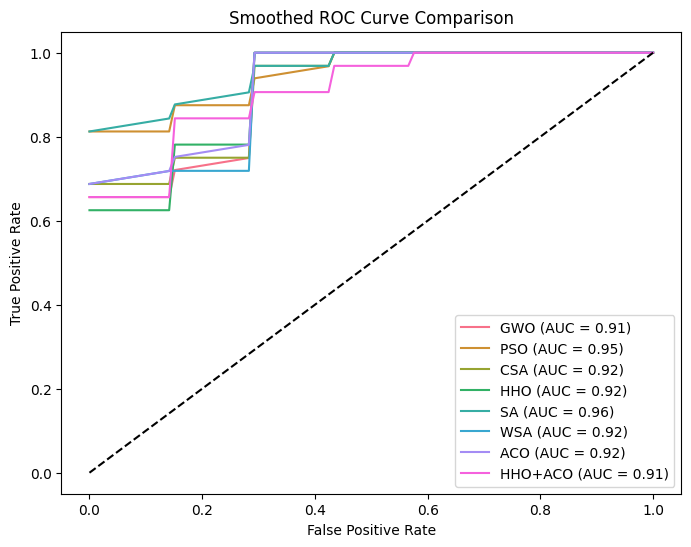

In [ ]:
# Run evaluator
evaluator = FeatureSelectionEvaluator()
evaluator.train_and_evaluate(X_train, y_train, X_test, y_test)

# Plot results
evaluator.plot_results()

In [ ]:
import json
import os
import numpy as np

def save_feature_selection_results(evaluator, filename="feature_selection_results.json"):
    """
    Saves the results from a FeatureSelectionEvaluator object to a JSON file.

    Args:
        evaluator (FeatureSelectionEvaluator): The evaluator object containing results.
        filename (str): The filename to save the results into.
    """
    if not hasattr(evaluator, 'results'):
        raise AttributeError("The provided evaluator does not have a 'results' attribute.")

    # Convert NumPy arrays & types to standard Python types
    serializable_results = {}
    for algo, data in evaluator.results.items():
        serializable_results[algo] = {
            "selected_features": list(map(int, data["selected_features"])),  # Convert NumPy int64 to Python int
            "accuracy": float(data["accuracy"]),  # Convert NumPy float to Python float
            "fpr": list(map(float, data["fpr"])),  # Convert NumPy array to list of floats
            "tpr": list(map(float, data["tpr"])),  # Convert NumPy array to list of floats
            "roc_auc": float(data["roc_auc"])  # Convert NumPy float to Python float
        }

    with open(filename, "w") as f:
        json.dump(serializable_results, f, indent=4)

    print(f"\n📁 Results saved to: {os.path.abspath(filename)}")


In [ ]:
save_feature_selection_results(evaluator, filename="feature_selection_results_d1.json")


📁 Results saved to: /content/feature_selection_results_d1.json


In [ ]:
# Run Genetic Algorithm using only X_train
ga_selector = GeneticFeatureSelector(X_train, y_train, n_generations=10, population_size=20)
selected_features = ga_selector.run_ga()

print("\n✅ Selected Features:", selected_features)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	20    
1  	15    
2  	12    
3  	18    
4  	15    
5  	17    
6  	18    
7  	17    
8  	16    
9  	20    
10 	11    

✅ Selected Features: ['MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'Jitter:DDP', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:DDA', 'NHR', 'DFA', 'spread2', 'D2', 'PPE']


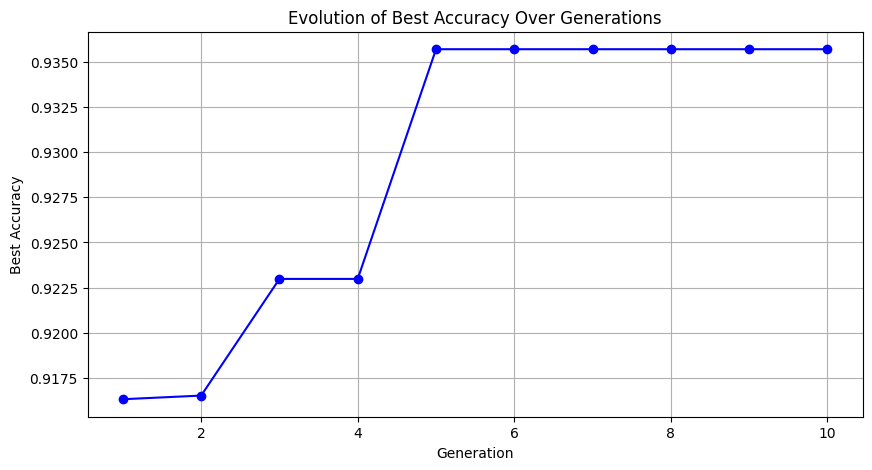

In [ ]:
# Plot best accuracy per generation
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_generations + 1), best_accuracies, marker='o', linestyle='-', color='blue')
plt.xlabel("Generation")
plt.ylabel("Best Accuracy")
plt.title("Evolution of Best Accuracy Over Generations")
plt.grid()
plt.show()

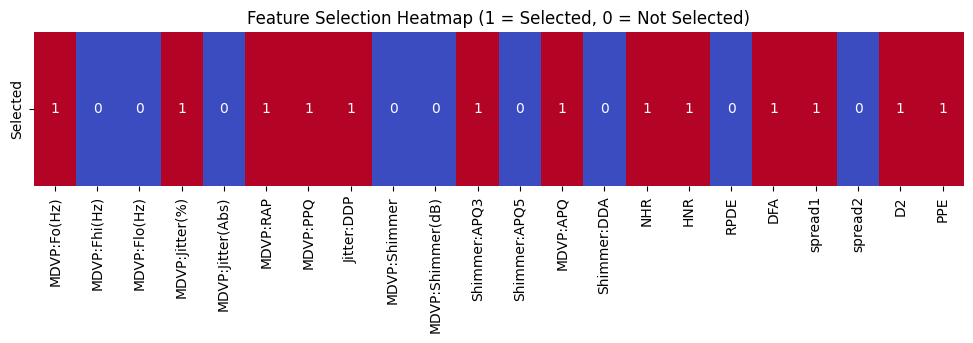

In [ ]:
# Convert selected features into a binary selection mask
feature_mask = np.array(best_individual).reshape(1, -1)

# Create a heatmap to visualize selected features
plt.figure(figsize=(12, 2))
sns.heatmap(feature_mask, cmap="coolwarm", annot=True, xticklabels=feature_names, yticklabels=["Selected"], cbar=False)
plt.title("Feature Selection Heatmap (1 = Selected, 0 = Not Selected)")
plt.xticks(rotation=90)
plt.show()

<ipython-input-11-739d7bda38e5>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(np.array(feature_names)[sorted_idx], rotation=90)
<ipython-input-11-739d7bda38e5>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(np.array(selected_features)[sorted_idx], rotation=90)


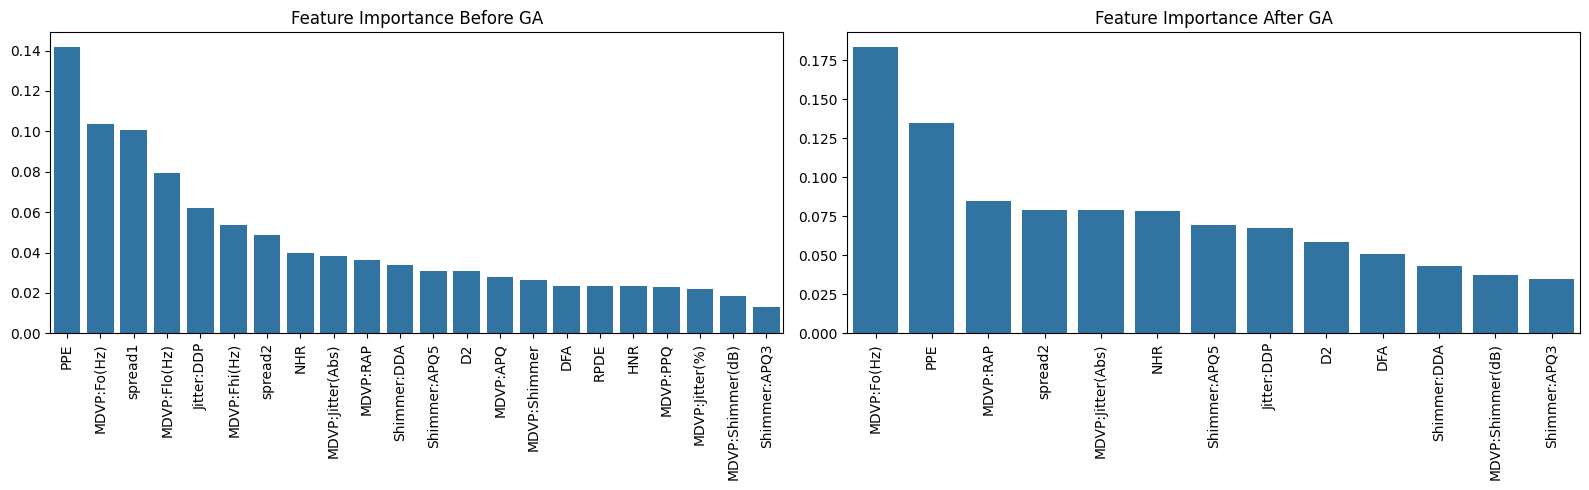

In [ ]:
# Train Random Forest with All Features
rf_all = RandomForestClassifier(random_state=42, n_estimators=100)
rf_all.fit(X_train, y_train)
feature_importances_all = rf_all.feature_importances_

# Train Random Forest with Selected Features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

rf_selected = RandomForestClassifier(random_state=42, n_estimators=100)
rf_selected.fit(X_train_selected, y_train)
feature_importances_selected = rf_selected.feature_importances_

# Plot Feature Importance Before vs After
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Before GA (All Features)
sorted_idx = np.argsort(feature_importances_all)[::-1]
sns.barplot(x=np.array(feature_names)[sorted_idx], y=feature_importances_all[sorted_idx], ax=axes[0])
axes[0].set_title("Feature Importance Before GA")
axes[0].set_xticklabels(np.array(feature_names)[sorted_idx], rotation=90)

# After GA (Selected Features)
sorted_idx = np.argsort(feature_importances_selected)[::-1]
sns.barplot(x=np.array(selected_features)[sorted_idx], y=feature_importances_selected[sorted_idx], ax=axes[1])
axes[1].set_title("Feature Importance After GA")
axes[1].set_xticklabels(np.array(selected_features)[sorted_idx], rotation=90)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test set
accuracy_selected = rf_selected.score(X_test_selected, y_test)
print("\n✅ Test Accuracy with Selected Features:", accuracy_selected)


✅ Test Accuracy with Selected Features: 0.9230769230769231


In [ ]:
# Train Random Forest with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

best_model = RandomForestClassifier(random_state=42, n_estimators=100)
best_model.fit(X_train_selected, y_train)

# Evaluate on test data
accuracy = best_model.score(X_test_selected, y_test)
print("\nTest Accuracy with Selected Features:", accuracy)


Test Accuracy with Selected Features: 0.9230769230769231


In [ ]:
# 🔹 Initialize Feature Selection Algorithms
aco = AntColonyFeatureSelector(num_ants=20, num_iterations=30)
wso = WolfSearchFeatureSelector(num_wolves=15, max_iter=25)

# 🔹 Perform Feature Selection using Ant Colony Optimization
selected_features_aco = aco.optimize(X_train, y_train)
print(f"Selected Features (ACO): {selected_features_aco}")

# 🔹 Perform Feature Selection using Wolf Search Algorithm
selected_features_wsa = wso.optimize(X_train, y_train)
print(f"Selected Features (WSA): {selected_features_wsa}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:15:19] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


✅ ACO Selected Features (Indices): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
Selected Features (ACO): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
✅ WSA Selected Features (Indices): [0, 2, 3, 5, 6, 7, 8, 9, 11, 17, 19, 21]
Selected Features (WSA): [ 0  2  3  5  6  7  8  9 11 17 19 21]


In [ ]:
hho_aco = HarrisHawksAntColonyFeatureSelection()
selected_features_hho_aco = hho_aco.optimize(X_train, y_train)
print(f"Final Selected Features (HHO + ACO): {selected_features_hho_aco}")

print("📌 Selected Feature Indices:", selected_features)
print("🎯 Selected Features:", X.columns[selected_features].tolist())

Final Selected Features (HHO + ACO): [0, 2, 4, 5, 6, 8, 13, 15, 18, 20, 21]
📌 Selected Feature Indices: [ 0  1  2  7  9 13 14 16 18 19 21]
🎯 Selected Features: ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'Jitter:DDP', 'MDVP:Shimmer(dB)', 'Shimmer:DDA', 'NHR', 'RPDE', 'spread1', 'spread2', 'PPE']


In [ ]:
X_sel = X_train.iloc[:, selected_features_aco]
X_sel.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
5,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,0.456,...,0.03243,0.06985,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775
135,110.453,127.611,105.554,0.00494,0.00004,0.00244,0.00315,0.00731,0.04128,0.379,...,0.03316,0.06688,0.02529,17.707,0.653427,0.706687,-5.333619,0.322044,2.631793,0.228319
122,138.190,203.522,83.340,0.00704,0.00005,0.00406,0.00398,0.01218,0.04479,0.441,...,0.03220,0.07761,0.01968,18.305,0.538016,0.741480,-5.418787,0.160267,2.090438,0.229892
167,260.105,264.919,237.303,0.00339,0.00001,0.00205,0.00186,0.00616,0.02030,0.197,...,0.01367,0.03557,0.00910,21.083,0.440988,0.628058,-7.517934,0.160414,1.881767,0.075587
85,180.978,200.125,155.495,0.00406,0.00002,0.00220,0.00244,0.00659,0.03852,0.331,...,0.02877,0.06321,0.02782,16.176,0.583574,0.727747,-5.657899,0.315903,3.098256,0.200423


In [ ]:
num_samples = X_sel.shape[0]  # Number of training samples
n_bins = max(8, min(256, num_samples // 10))  # Adjust bins based on dataset size
# Train a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, max_depth=50, n_bins=n_bins)
model.fit(X_sel, y_train)

X_test_selected = X_test.iloc[:, selected_features_aco]
# Make predictions
y_pred = model.predict(X_test_selected)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print("y_test shape:", y_test.shape)
print("y_pred_prob shape:", y_pred_prob.shape)

y_test shape: (39,)
y_pred_prob shape: (39, 2)


In [ ]:
# Compute ROC AUC using built-in functions
y_pred_prob = model.predict_proba(X_test_selected)

# Ensure NumPy array conversion
y_test = np.array(y_test)  # Convert to NumPy array
y_pred_prob = np.array(y_pred_prob)  # Convert to NumPy array

if len(set(y_train)) == 2:  # Binary Classification
    roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])  # No .values needed
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
else:  # Multi-Class Classification (One-vs-Rest)
    from sklearn.preprocessing import label_binarize

    y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
    roc_auc = roc_auc_score(y_test_bin, y_pred_prob, multi_class="ovr")
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())

print(f"✅ Accuracy: {accuracy:.4f}")
print(f"🔥 ROC AUC: {roc_auc:.4f}")

✅ Accuracy: 0.9487
🔥 ROC AUC: 0.9040


In [ ]:
# Define parameter search space for Bayesian Optimization
param_space = {
    'n_estimators': (50, 300),
    'max_depth': (5, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'bootstrap': [True, False]
}

# Perform Bayesian Search
bayesian_search = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    search_spaces=param_space,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_iter=50,  # Number of iterations
    n_jobs=-1,
    verbose=2,
    random_state=42
)

bayesian_search.fit(X_train[selected_features], y_train)

# Print best parameters and accuracy
print("\nBest parameters (Bayesian Optimization):", bayesian_search.best_params_)
print("Best accuracy (Bayesian Optimization):", bayesian_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
# Evaluate the best model from Bayesian Optimization (or others)
best_model = bayesian_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test[selected_features])

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (Best Model): {(test_accuracy * 100) : .3f}")

Test Accuracy (Best Model):  94.872


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

In [ ]:
# Convert X to a DataFrame
X = pd.DataFrame(X, columns=["Feature_" + str(i) for i in range(X.shape[1])])

# Calculate skewness for each feature
feature_skewness = X.apply(lambda col: skew(col), axis=0)

# Print skewness
print("Feature Skewness:")
print(feature_skewness)

# Identify features with high skewness (e.g., skew > 1 or skew < -1)
high_skew = feature_skewness[np.abs(feature_skewness) > 1]
print("\nHighly Skewed Features:")
print(high_skew)

Feature Skewness:
Feature_0     0.587176
Feature_1     2.522549
Feature_2     1.207966
Feature_3     3.061165
Feature_4     2.628650
Feature_5     3.334801
Feature_6     3.050196
Feature_7     3.336141
Feature_8     1.653634
Feature_9     1.983976
Feature_10    1.568392
Feature_11    1.784831
Feature_12    2.597864
Feature_13    1.568433
Feature_14    4.188173
Feature_15   -0.510353
Feature_16   -0.142297
Feature_17   -0.032958
Feature_18    0.428808
Feature_19    0.143317
Feature_20    0.427066
Feature_21    0.791343
dtype: float64

Highly Skewed Features:
Feature_1     2.522549
Feature_2     1.207966
Feature_3     3.061165
Feature_4     2.628650
Feature_5     3.334801
Feature_6     3.050196
Feature_7     3.336141
Feature_8     1.653634
Feature_9     1.983976
Feature_10    1.568392
Feature_11    1.784831
Feature_12    2.597864
Feature_13    1.568433
Feature_14    4.188173
dtype: float64


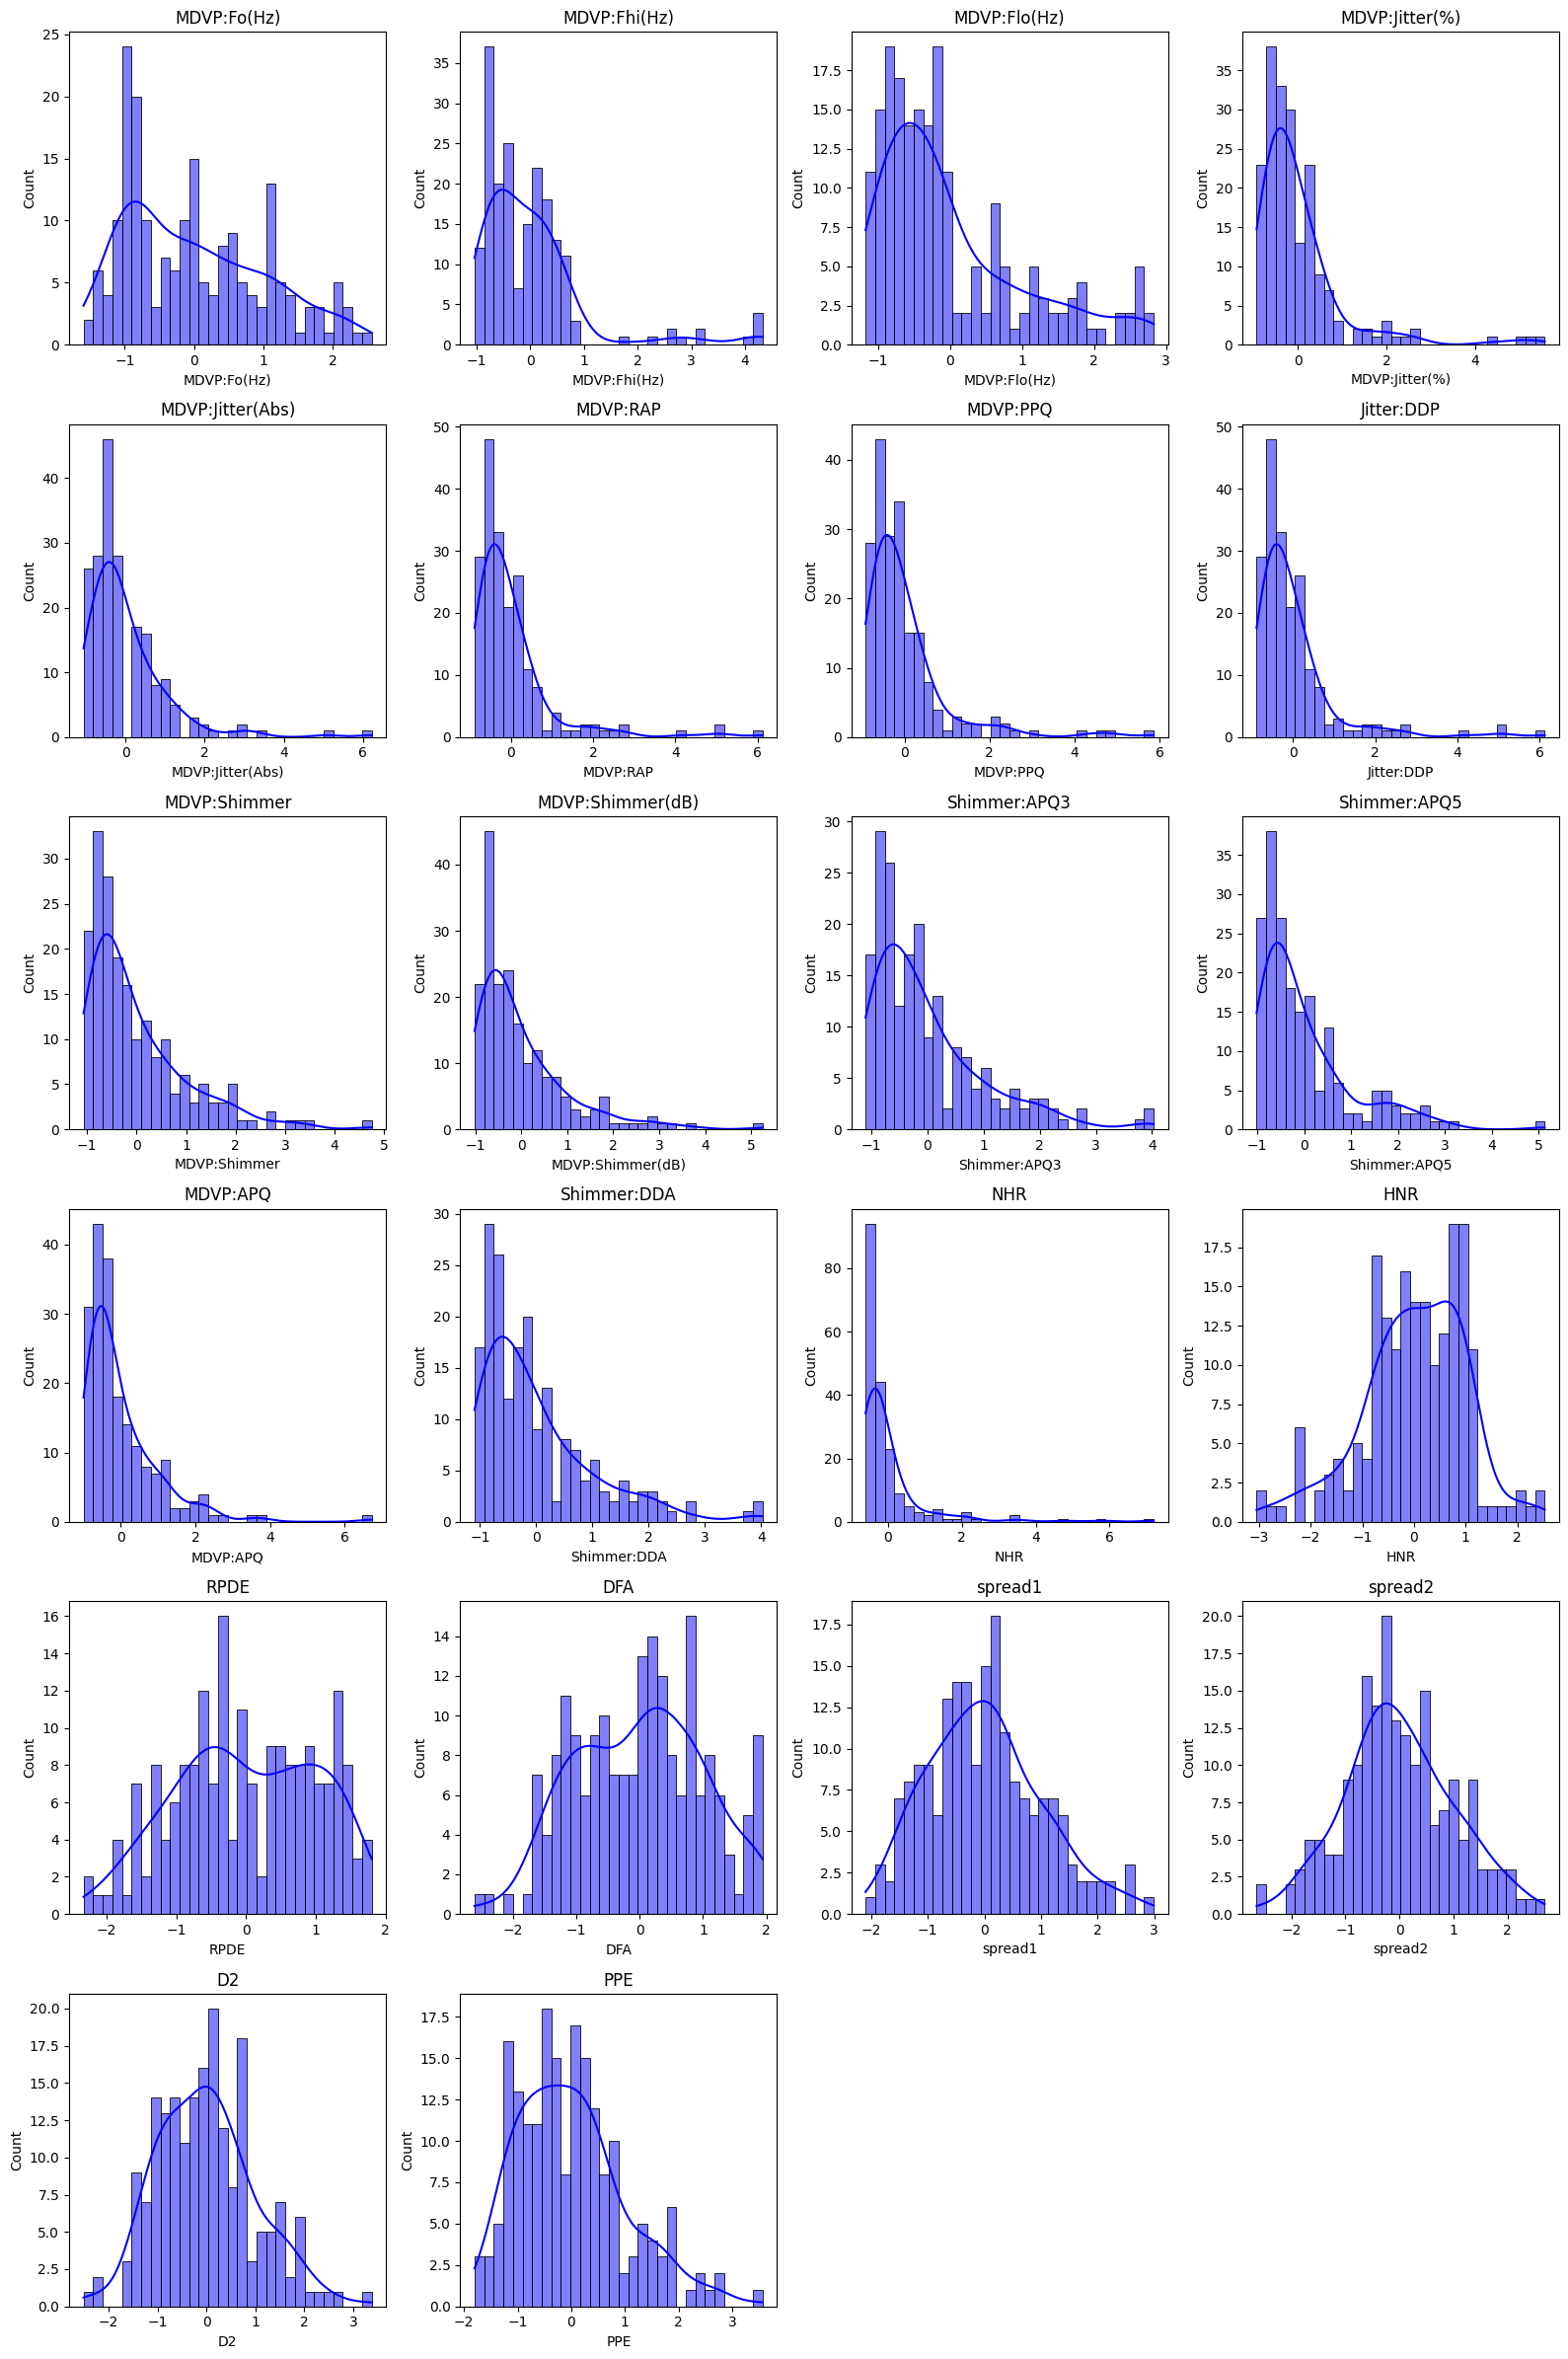

In [ ]:
# Plot the distributions
import math

rows = math.ceil(len(X.columns) / 4)
plt.figure(figsize=(16, rows * 4))

for i, column in enumerate(X.columns, 1):
    plt.subplot(rows, 4, i)
    sns.histplot(X[column], kde=True, bins=30, color='blue')
    plt.title(column)
plt.tight_layout()

plt.show()


In [ ]:
# Apply log transformation to highly skewed features
for col in high_skew.index:
    X[col] = np.log1p(X[col])  # log(1 + x) to avoid issues with zero

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Grid Search
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters from Grid Search
print("Best parameters (Grid Search):", grid_search.best_params_)
print("Best accuracy (Grid Search):", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters (Grid Search): {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best accuracy (Grid Search): 0.9356854838709678


In [ ]:
from scipy.stats import randint

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None] + list(range(10, 50, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Perform Random Search
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # Number of random combinations to try
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit Random Search
random_search.fit(X_train, y_train)

# Best parameters from Random Search
print("Best parameters (Random Search):", random_search.best_params_)
print("Best accuracy (Random Search):", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters (Random Search): {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 123}
Best accuracy (Random Search): 0.929233870967742


In [ ]:
# Define the parameter space for Bayesian Optimization
param_space = {
    'n_estimators': (50, 200),
    'max_depth': (10, 50),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10),
    'bootstrap': [True, False]
}

# Perform Bayesian Optimization
bayesian_search = BayesSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    search_spaces=param_space,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    n_iter=50,  # Number of iterations
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit Bayesian Search
bayesian_search.fit(X_train, y_train)

# Best parameters from Bayesian Optimization
print("Best parameters (Bayesian Optimization):", bayesian_search.best_params_)
print("Best accuracy (Bayesian Optimization):", bayesian_search.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [ ]:
# Evaluate the best model from Bayesian Optimization (or others)
best_model = bayesian_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy (Best Model): {(test_accuracy * 100) : .3f}")

Test Accuracy (Best Model):  92.308


#**Plots and Visualizations**

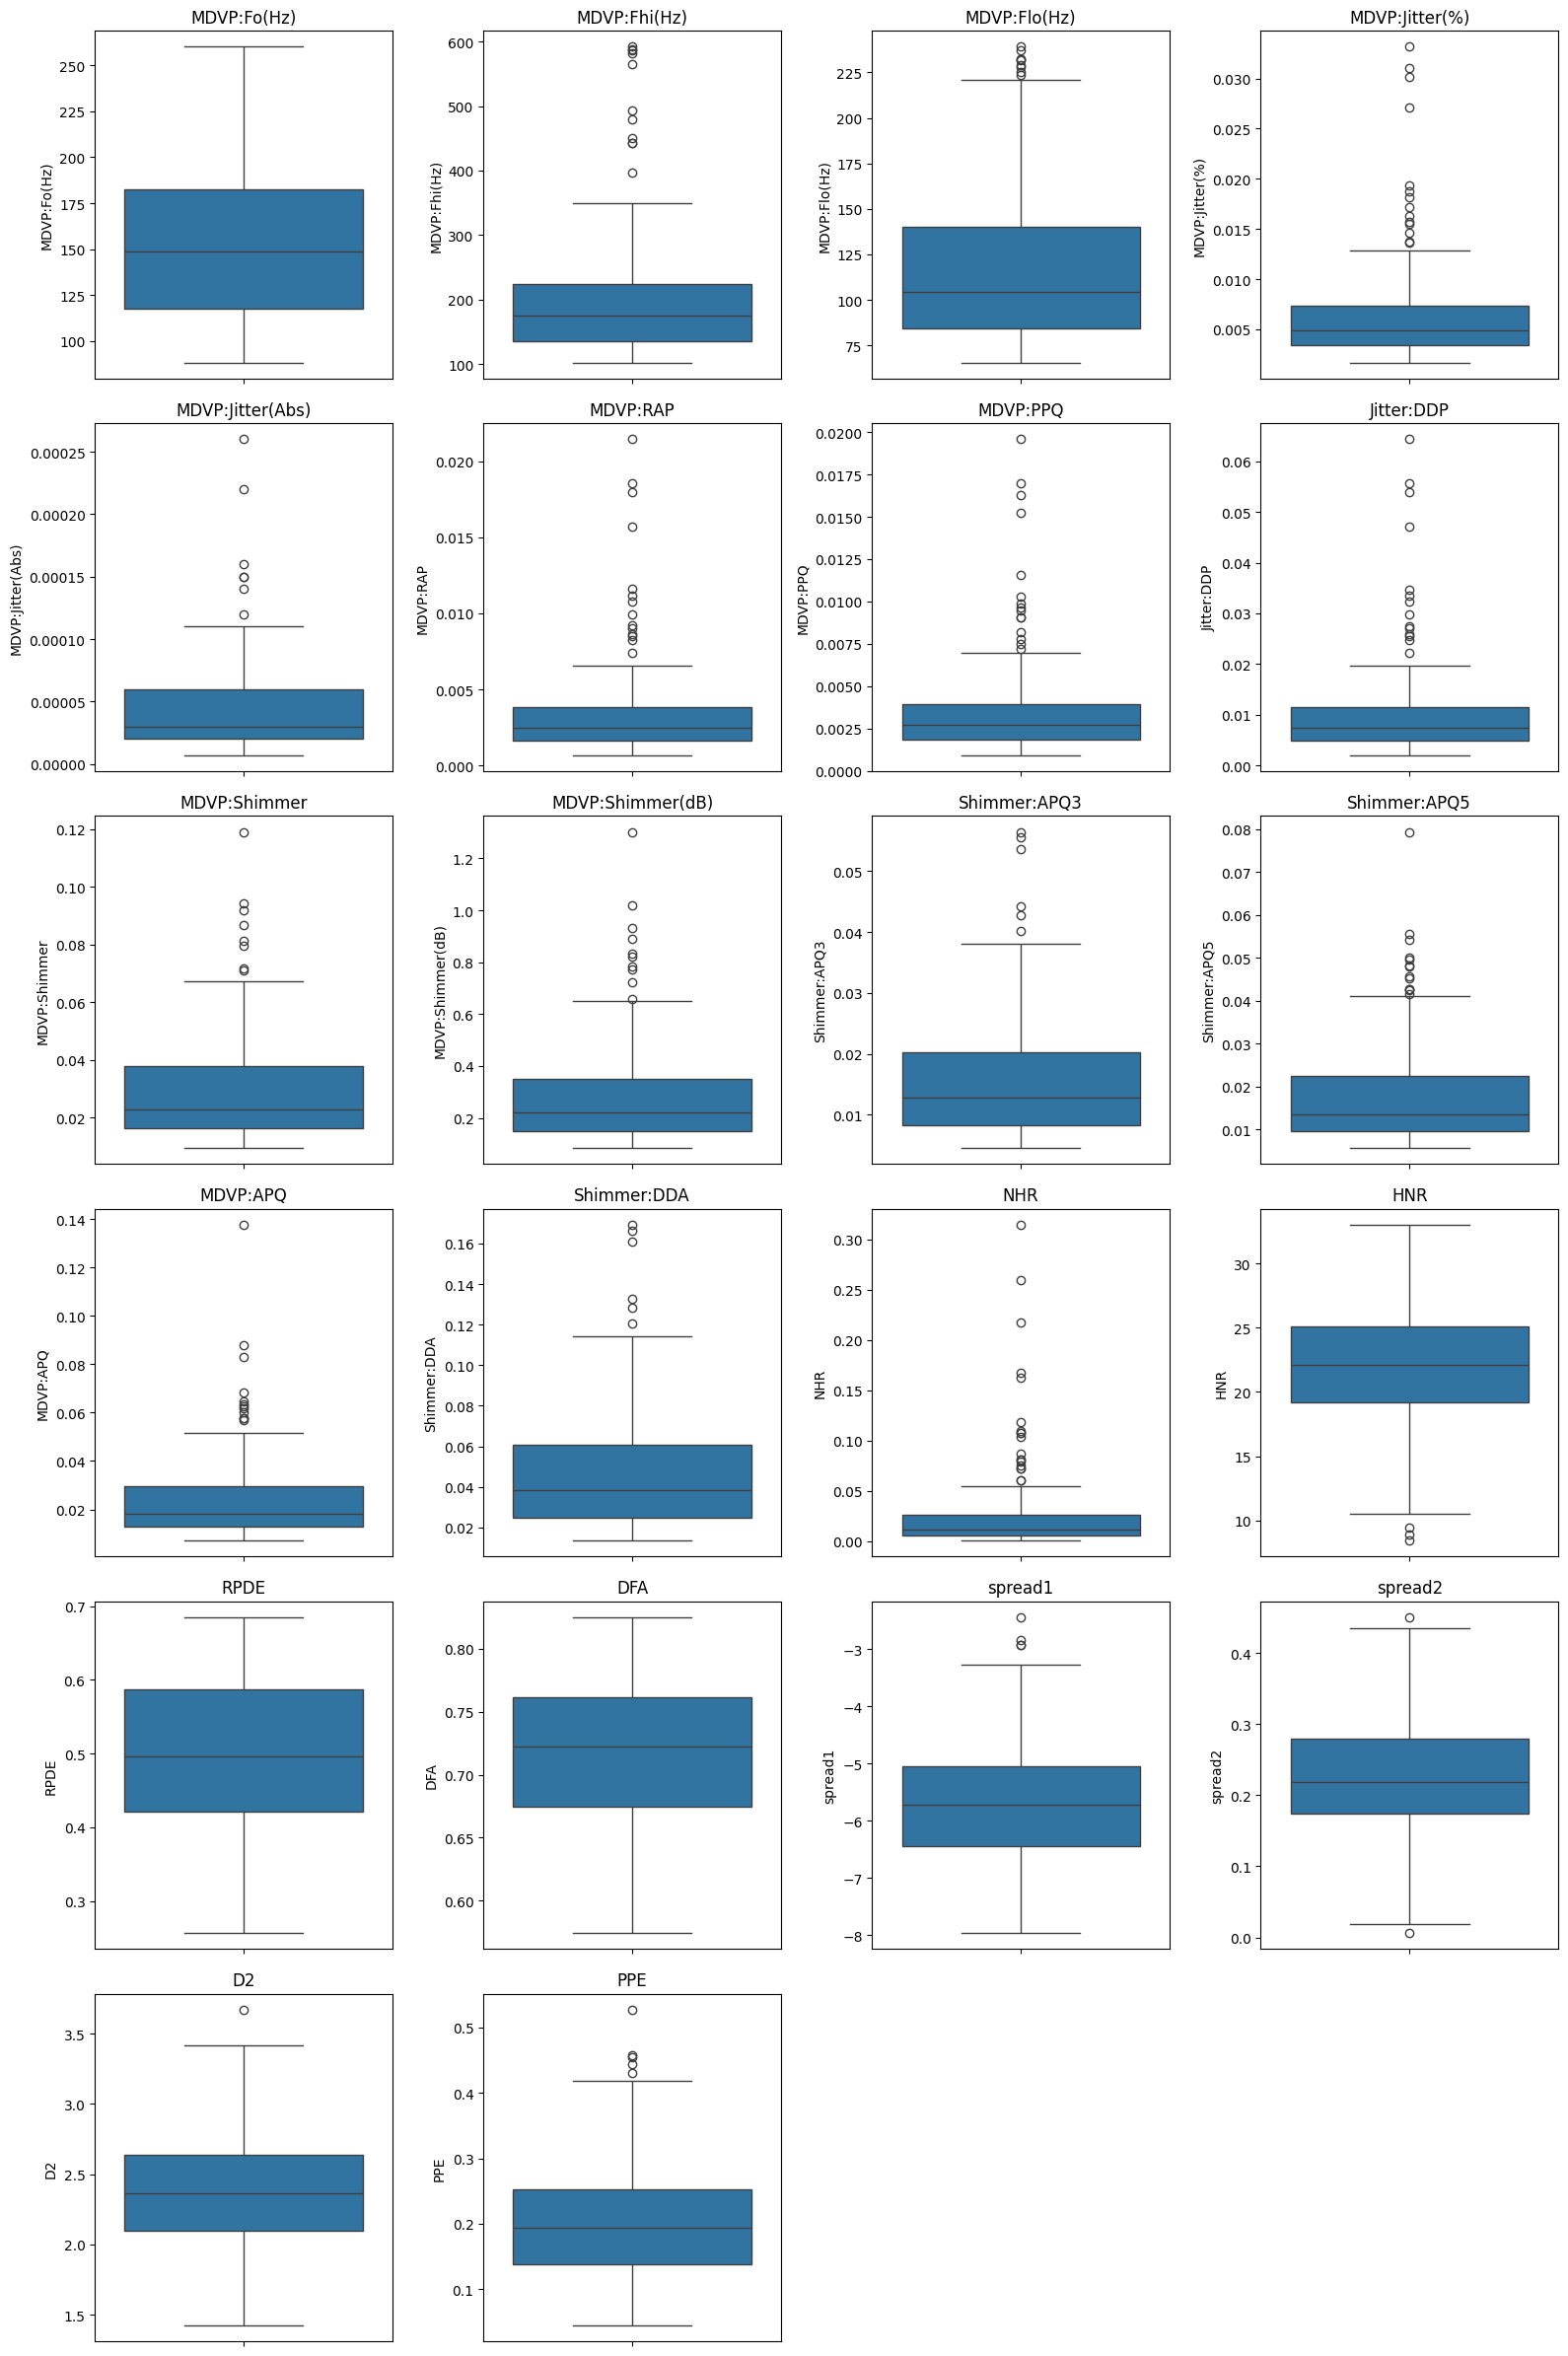

In [ ]:
# Set up the figure for boxplots
plt.figure(figsize=(16, rows * 4))

for i, column in enumerate(X.columns, 1):
    plt.subplot(rows, 4, i)
    sns.boxplot(y=X[column])
    plt.title(column)

plt.tight_layout()
plt.show()

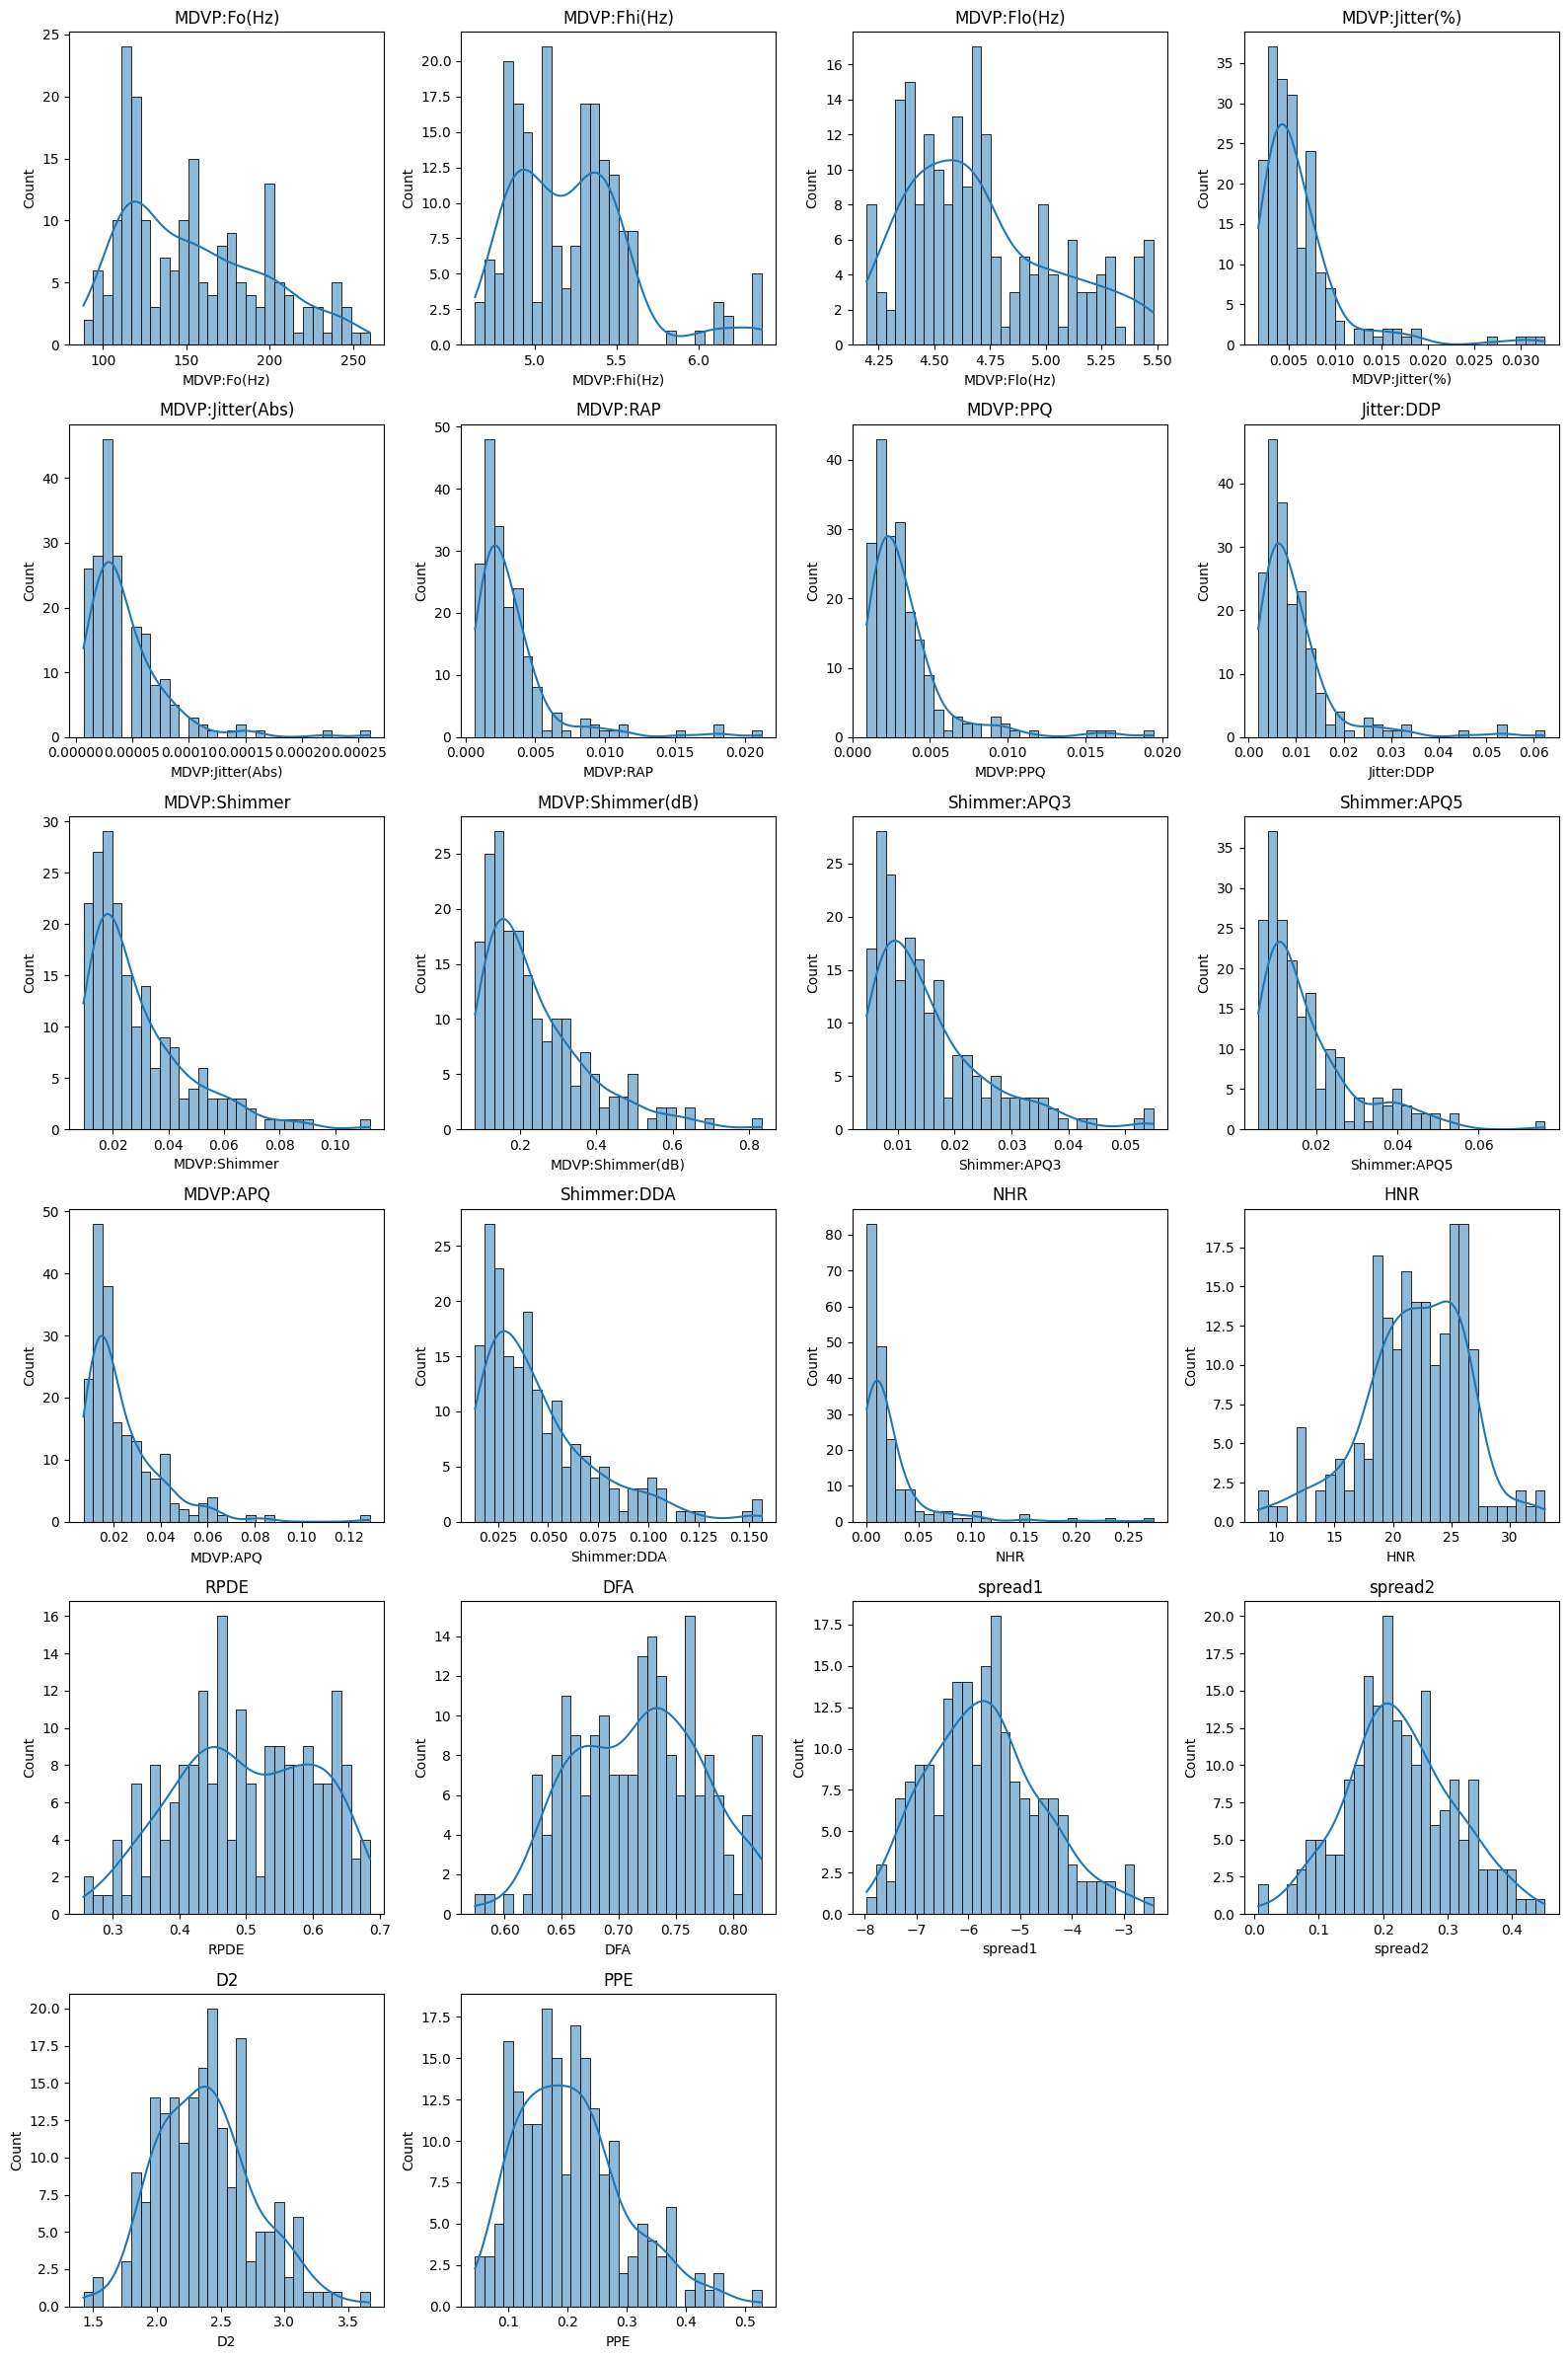

In [ ]:
# Set up the figure for histograms
num_features = X.shape[1]
rows = (num_features + 3) // 4  # Arrange 4 plots per row
plt.figure(figsize=(16, rows * 4))

for i, column in enumerate(X.columns, 1):
    plt.subplot(rows, 4, i)
    sns.histplot(X[column], kde=True, bins=30)
    plt.title(column)

plt.tight_layout()
plt.show()

#**Parkinsin Second Dataset - Pycaret**


In [ ]:
df = pd.read_csv("/content/Parkinson3.csv")
df

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,250,0,0.80903,0.56355,0.28385,417,416,0.004627,0.000052,0.00064,...,3.0706,3.0190,3.1212,2.4921,3.5844,3.5400,3.3805,3.2003,6.8671,0
752,250,0,0.16084,0.56499,0.59194,415,413,0.004550,0.000220,0.00143,...,1.9704,1.7451,1.8277,2.4976,5.2981,4.2616,6.3042,10.9058,28.4170,0
753,251,0,0.88389,0.72335,0.46815,381,380,0.005069,0.000103,0.00076,...,51.5607,44.4641,26.1586,6.3076,2.8601,2.5361,3.5377,3.3545,5.0424,0
754,251,0,0.83782,0.74890,0.49823,340,339,0.005679,0.000055,0.00092,...,19.1607,12.8312,8.9434,2.2044,1.9496,1.9664,2.6801,2.8332,3.7131,0


In [ ]:
df.columns

Index(['id', 'gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=755)

In [ ]:
# prompt: use pycaret to perform everything on the above parkinsons dataset

!pip install pycaret

import pandas as pd
from pycaret.classification import *


In [ ]:
# Load the dataset
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
data = pd.read_csv("/content/Parkinson3.csv")
data = data.drop(columns=['id+'])

# Setup PyCaret
clf = setup(data = data, target = 'class', session_id=123)

# Compare models
best_model = compare_models()

# Tune the best model
tuned_best_model = tune_model(best_model)

# Evaluate the model
evaluate_model(tuned_best_model)

# Predict on hold-out set
predict_model(tuned_best_model);

# Finalize the model
final_model = finalize_model(tuned_best_model)

# Save the model
save_model(final_model, 'parkinsons_model')

,Description,Value
0,Session id,123
1,Target,class
2,Target type,Binary
3,Original data shape,"(756, 754)"
4,Transformed data shape,"(756, 754)"
5,Transformed train set shape,"(529, 754)"
6,Transformed test set shape,"(227, 754)"
7,Numeric features,753
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9018,0.9478,0.9798,0.8987,0.9371,0.7141,0.7328,9.8460
rf,Random Forest Classifier,0.8790,0.9155,0.9697,0.8812,0.9229,0.6445,0.6668,0.6600
gbc,Gradient Boosting Classifier,0.8790,0.9255,0.9671,0.8831,0.9228,0.6456,0.6641,5.6750
ada,Ada Boost Classifier,0.8752,0.9273,0.9470,0.8937,0.9187,0.6501,0.6625,1.3220
et,Extra Trees Classifier,0.8752,0.9386,0.9772,0.8717,0.9212,0.6254,0.6532,0.2790
xgboost,Extreme Gradient Boosting,0.8639,0.9288,0.9545,0.8760,0.9128,0.6045,0.6246,1.9210
dt,Decision Tree Classifier,0.8109,0.7550,0.8682,0.8794,0.8722,0.5033,0.5095,0.2860
lr,Logistic Regression,0.7770,0.7164,0.9392,0.7987,0.8626,0.2839,0.3276,0.8930
svm,SVM - Linear Kernel,0.7467,0.3170,1.0000,0.7467,0.8550,0.0000,0.0000,0.1430
dummy,Dummy Classifier,0.7467,0.5000,1.0000,0.7467,0.8550,0.0000,0.0000,0.1030


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8491,0.8808,0.9500,0.8636,0.9048,0.5451,0.5597
1,0.8868,0.9538,0.9500,0.9048,0.9268,0.6775,0.6814
2,0.8679,0.8885,0.9750,0.8667,0.9176,0.5901,0.6171
3,0.8679,0.9019,0.9500,0.8837,0.9157,0.6131,0.6217
4,0.9057,0.9173,1.0000,0.8889,0.9412,0.7072,0.7396
5,0.8491,0.8901,0.8718,0.9189,0.8947,0.6287,0.6314
6,0.8491,0.9103,0.9487,0.8605,0.9024,0.5726,0.5861
7,0.8491,0.8974,0.9744,0.8444,0.9048,0.5499,0.5842
8,0.8868,0.9762,1.0000,0.8667,0.9286,0.6624,0.7037


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9163,0.9533,0.9763,0.9167,0.9456,0.7654,0.7725


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['gender', 'PPE', 'DFA', 'RPDE',
                                              'numPulses', 'numPeriodsPulses',
                                              'meanPeriodPulses',
                                              'stdDevPeriodPulses',
                                              'locPctJitter', 'locAbsJitter',
                                              'rapJitter', 'ppq5Jitter',
                                              'ddpJitter', 'locShimmer',
                                              'locDbShimmer', 'apq3Shimmer',
                                              'apq5Shimmer', 'apq11Shimmer',
                                              'ddaSh...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type=

#**Parkinson Second dataset with filter methods**

In [ ]:
# Load the dataset
file_path = "/content/Parkinson3.csv"
df = pd.read_csv(file_path)

# Display basic information and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


(None,
    id  gender      PPE      DFA     RPDE  numPulses  numPeriodsPulses  \
 0   0       1  0.85247  0.71826  0.57227        240               239   
 1   0       1  0.76686  0.69481  0.53966        234               233   
 2   0       1  0.85083  0.67604  0.58982        232               231   
 3   1       0  0.41121  0.79672  0.59257        178               177   
 4   1       0  0.32790  0.79782  0.53028        236               235   
 
    meanPeriodPulses  stdDevPeriodPulses  locPctJitter  ...  \
 0          0.008064            0.000087       0.00218  ...   
 1          0.008258            0.000073       0.00195  ...   
 2          0.008340            0.000060       0.00176  ...   
 3          0.010858            0.000183       0.00419  ...   
 4          0.008162            0.002669       0.00535  ...   
 
    tqwt_kurtosisValue_dec_28  tqwt_kurtosisValue_dec_29  \
 0                     1.5620                     2.6445   
 1                     1.5589                  

In [ ]:
# Check for missing values
missing_values = df.isnull().sum().sum()

# Compute correlation with target variable
correlation_with_target = df.corr()['class'].sort_values(ascending=False)

missing_values, correlation_with_target.head(10)

(np.int64(0),
 class                   1.000000
 mean_MFCC_2nd_coef      0.398695
 tqwt_minValue_dec_12    0.395740
 tqwt_minValue_dec_11    0.366552
 tqwt_minValue_dec_13    0.365264
 std_9th_delta_delta     0.364333
 std_8th_delta_delta     0.364256
 std_7th_delta_delta     0.354239
 std_6th_delta_delta     0.349046
 std_8th_delta           0.342875
 Name: class, dtype: float64)

In [ ]:
import numpy as np

# Remove the 'id' column as it is not useful for model training
df.drop(columns=['id'], inplace=True)

# Compute correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix (to avoid duplicate values)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with high correlation (threshold > 0.75)
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.75)]

# Number of highly correlated features
len(high_corr_features), high_corr_features[:10]  # Displaying only first 10 for reference


(497,
 ['numPeriodsPulses',
  'meanPeriodPulses',
  'locAbsJitter',
  'rapJitter',
  'ppq5Jitter',
  'ddpJitter',
  'locDbShimmer',
  'apq3Shimmer',
  'apq5Shimmer',
  'apq11Shimmer'])

In [ ]:
# Drop highly correlated features
df_reduced = df.drop(columns=high_corr_features)

# Check new shape after removing correlated features
df_reduced.shape


(756, 257)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Apply Variance Thresholding (removing features with very low variance)
selector = VarianceThreshold(threshold=0.01)  # Removing near-constant features
df_var_filtered = df_reduced.iloc[:, selector.fit_transform(df_reduced.drop(columns=['class'])).shape[1]]

# Check new shape after variance thresholding
df_var_filtered.shape


(756,)

In [ ]:
# Apply Variance Thresholding correctly
X = df_reduced.drop(columns=['class'])  # Features
y = df_reduced['class']  # Target variable

# Fit variance thresholding
selector = VarianceThreshold(threshold=0.01)
X_var_filtered = selector.fit_transform(X)

# Convert back to DataFrame
selected_features = X.columns[selector.get_support()]
df_var_filtered = pd.DataFrame(X_var_filtered, columns=selected_features)

# Add the target variable back
df_var_filtered['class'] = y

# Check new shape after filtering
df_var_filtered.shape


(756, 104)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Apply Min-Max Scaling to features (excluding the target variable)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_var_filtered.drop(columns=['class']))

# Convert back to DataFrame with column names
df_scaled = pd.DataFrame(X_scaled, columns=df_var_filtered.drop(columns=['class']).columns)

# Add target variable back
df_scaled['class'] = df_var_filtered['class']

# Check first few rows after scaling
df_scaled.head()


,gender,PPE,RPDE,numPulses,minIntensity,f1,f2,f3,f4,b1,...,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,class
0,1.0,0.936278,0.583000,0.262983,0.748251,0.388236,0.232903,0.501803,0.588509,0.018508,...,0.011875,0.113607,0.072060,0.011239,0.002753,0.001415,0.000313,0.000576,0.000219,1
1,1.0,0.837434,0.537514,0.256354,0.701531,0.420381,0.219573,0.470997,0.510722,0.009498,...,0.052111,0.125915,0.051986,0.002455,0.000586,0.001529,0.000241,0.000594,0.000206,1
2,1.0,0.934385,0.607479,0.254144,0.615493,0.399930,0.233383,0.458529,0.599988,0.031040,...,0.019967,0.129403,0.064748,0.003430,0.001398,0.004916,0.000279,0.000557,0.000229,1
3,0.0,0.426804,0.611315,0.194475,0.862436,0.748200,0.379249,0.844212,0.820872,0.047585,...,0.053163,0.025973,0.107072,0.016686,0.003760,0.001152,0.001017,0.015906,0.009530,1
4,0.0,0.330615,0.524431,0.258564,0.868565,0.783230,0.390901,0.867210,0.802612,0.082152,...,0.022565,0.030587,0.074105,0.013088,0.002619,0.000721,0.001015,0.018467,0.019569,1


In [ ]:
X = df_scaled.drop(columns=['class'])
y = df_scaled['class']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
feature_names = X.columns.tolist()

In [ ]:
#--- Optional ----
from sklearn.feature_selection import mutual_info_classif

# Compute Mutual Information scores
X_final = df_scaled.drop(columns=['class'])
y_final = df_scaled['class']
mi_scores = mutual_info_classif(X_final, y_final, discrete_features=False)

# Create a DataFrame with scores
mi_scores_df = pd.DataFrame({'Feature': X_final.columns, 'MI Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)

# Select top 50 most important features based on Mutual Information
top_features = mi_scores_df.head(50)['Feature'].tolist()

# Final dataset with selected features
df_final = df_scaled[top_features + ['class']]

# Check final dataset shape
df_final.shape

(756, 51)

In [ ]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled.drop(columns=['class']), df_scaled['class'], test_size=0.2, random_state=42, stratify=df_scaled['class']
)

# Define the hyperparameter search space for Random Forest
param_space = {
    'n_estimators': Integer(50, 500),  # Number of trees
    'max_depth': Integer(5, 100),  # Maximum depth of trees
    'min_samples_split': Integer(2, 20),  # Minimum samples to split a node
    'min_samples_leaf': Integer(1, 10),  # Minimum samples per leaf
    'max_features': Real(0.1, 1.0, prior='uniform'),  # Fraction of features considered per split
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Apply Bayesian Optimization
bayes_search = BayesSearchCV(
    rf,
    param_space,
    n_iter=30,  # Number of iterations for search
    cv=10,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Train model with Bayesian optimization
bayes_search.fit(X_train, y_train)

# Get best parameters
best_params = bayes_search.best_params_
print("Best Parameters:", best_params)

# Train the best model
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predictions
y_pred = best_rf.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: OrderedDict([('max_depth', 100), ('max_features', 0.7327670112025219), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 500)])
Test Accuracy: 0.8421
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.51      0.62        39
           1       0.85      0.96      0.90       113

    accuracy                           0.84       152
   macro avg       0.83      0.73      0.76       152
weighted avg       0.84      0.84      0.83       152



#**Second Dataset with Genetic Algorithm**

In [ ]:
# Load the dataset
file_path = "/content/Parkinson3.csv"
df = pd.read_csv(file_path)
# Remove the 'id' column as it is not useful for model training
df.drop(columns=['id'], inplace=True)
df

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0,0.80903,0.56355,0.28385,417,416,0.004627,0.000052,0.00064,0.000003,...,3.0706,3.0190,3.1212,2.4921,3.5844,3.5400,3.3805,3.2003,6.8671,0
752,0,0.16084,0.56499,0.59194,415,413,0.004550,0.000220,0.00143,0.000006,...,1.9704,1.7451,1.8277,2.4976,5.2981,4.2616,6.3042,10.9058,28.4170,0
753,0,0.88389,0.72335,0.46815,381,380,0.005069,0.000103,0.00076,0.000004,...,51.5607,44.4641,26.1586,6.3076,2.8601,2.5361,3.5377,3.3545,5.0424,0
754,0,0.83782,0.74890,0.49823,340,339,0.005679,0.000055,0.00092,0.000005,...,19.1607,12.8312,8.9434,2.2044,1.9496,1.9664,2.6801,2.8332,3.7131,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop(columns=['class'])
y = df['class']

# Separate the 'gender' column before scaling
gender_column = X['gender']
X_features = X.drop(columns=['gender'])  # Drop the 'gender' column for scaling

# Apply Decimal Scaling to columns with small values
for column in X_features.columns:
    max_abs_value = X_features[column].abs().max()

    # Check if the max absolute value is very small (e.g., < 0.01)
    if max_abs_value < 0.01:
        # Find the appropriate power of 10 to scale the feature
        scale_power = int(np.floor(np.log10(max_abs_value)))
        X_features[column] = X_features[column] / (10 ** scale_power)
        print(f"Decimal Scaling applied to {column} with power of 10^{scale_power}")

# Apply MinMaxScaler to the remaining columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Convert the scaled data back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_features.columns)

# Recombine the scaled features with the 'gender' column
X_scaled_final = pd.concat([X_scaled_df, gender_column], axis=1)

X_scaled = X_scaled_final.astype('float16')
y = y.astype('int8')
X_scaled['gender'] = X_scaled['gender'].astype('int8')

# Split into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Get feature names (including 'gender')
feature_names = X_scaled.columns.tolist()

# Display the final scaled data
X_scaled

Decimal Scaling applied to stdDevPeriodPulses with power of 10^-3
Decimal Scaling applied to locAbsJitter with power of 10^-4
Decimal Scaling applied to mean_delta_delta_log_energy with power of 10^-3
Decimal Scaling applied to mean_1st_delta_delta with power of 10^-3
Decimal Scaling applied to mean_2nd_delta_delta with power of 10^-3
Decimal Scaling applied to mean_3rd_delta_delta with power of 10^-3
Decimal Scaling applied to mean_4th_delta_delta with power of 10^-3
Decimal Scaling applied to mean_5th_delta_delta with power of 10^-3
Decimal Scaling applied to mean_6th_delta_delta with power of 10^-3
Decimal Scaling applied to mean_7th_delta_delta with power of 10^-3
Decimal Scaling applied to mean_8th_delta_delta with power of 10^-3
Decimal Scaling applied to mean_9th_delta_delta with power of 10^-3
Decimal Scaling applied to mean_10th_delta_delta with power of 10^-3
Decimal Scaling applied to mean_11th_delta_delta with power of 10^-3
Decimal Scaling applied to mean_12th_delta_delta 

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,gender
0,0.627441,0.256104,0.605957,-0.846680,-0.842285,0.933105,-0.407227,-0.054993,0.037842,0.066345,...,-0.584961,-0.619629,-0.576660,-0.482178,-0.399414,-0.484619,-0.774902,-0.814941,-0.366699,1
1,0.121643,-0.080444,0.368408,-0.907227,-0.902832,1.040039,-0.426025,-0.142578,-0.027695,-0.086731,...,-0.584961,-0.589844,0.193115,0.016190,-0.067139,-0.175537,-0.526855,-0.583008,0.400391,1
2,0.618164,-0.349854,0.733398,-0.927734,-0.922852,1.084961,-0.443604,-0.214966,-0.088867,-0.035706,...,-0.584961,-0.628906,-0.356201,-0.156006,-0.067566,-0.463379,-0.755859,-0.804199,-0.780762,1
3,-1.980469,1.381836,0.753418,-1.472656,-1.466797,2.464844,-0.275391,0.710449,1.256836,0.902832,...,-0.532227,-0.591309,-0.522461,0.008400,-0.449951,-0.470947,-0.633301,-0.588379,-0.801758,0
4,-2.472656,1.398438,0.300049,-0.887207,-0.882812,0.986816,3.144531,1.152344,1.178711,1.076172,...,-0.475586,-0.521484,-0.489990,-0.404785,-0.249634,-0.042023,-0.419434,-0.672363,-0.741699,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,0.370850,-1.964844,-1.494141,0.937988,0.939453,-0.949707,-0.454834,-0.641602,-0.601562,-0.535645,...,-0.548828,-0.607910,-0.605957,-0.567871,-0.485840,-0.541016,-0.726562,-0.800781,-0.719727,0
752,-3.460938,-1.943359,0.749023,0.917969,0.909180,-0.991699,-0.224121,-0.340576,-0.447266,-0.454102,...,-0.575195,-0.646973,-0.656738,-0.567871,-0.389404,-0.496826,-0.540527,-0.266602,-0.089600,0
753,0.813477,0.329102,-0.152222,0.575195,0.577148,-0.707031,-0.385498,-0.595703,-0.562012,-0.504883,...,0.600098,0.663086,0.296631,-0.377686,-0.526367,-0.602539,-0.716797,-0.790039,-0.772949,0
754,0.541016,0.695801,0.066772,0.161621,0.164307,-0.373047,-0.450928,-0.534668,-0.502441,-0.443848,...,-0.167725,-0.306885,-0.377930,-0.582520,-0.577637,-0.637207,-0.771484,-0.826172,-0.811523,0


In [ ]:
# Run evaluator
evaluator = FeatureSelectionEvaluator()
evaluator.train_and_evaluate(X_train, y_train, X_test, y_test)

# Plot results
evaluator.plot_results()


🔍 Running GWO Feature Selection...
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️
⚠️ ERROR: Selected features are empty. Fixing... ⚠️


In [ ]:
# Run Genetic Algorithm using only X_train
ga_selector = GeneticFeatureSelector(X_train, y_train, n_generations=20, population_size=30)
selected_features = ga_selector.run_ga()

print("\n✅ Selected Features:", selected_features)

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	40    
1  	35    
2  	32    
3  	37    
4  	24    
5  	34    
6  	37    
7  	40    
8  	33    
9  	38    
10 	34    
11 	33    
12 	29    
13 	34    
14 	33    
15 	32    
16 	38    
17 	37    
18 	33    
19 	36    
20 	25    
21 	35    
22 	38    
23 	31    
24 	32    
25 	36    
26 	38    
27 	28    
28 	32    
29 	34    
30 	30    
31 	37    
32 	35    
33 	30    
34 	34    
35 	36    
36 	27    
37 	32    
38 	39    
39 	26    
40 	36    
41 	32    
42 	31    
43 	38    
44 	33    
45 	34    
46 	36    
47 	28    
48 	35    
49 	26    
50 	32    
51 	31    
52 	31    
53 	36    
54 	31    
55 	36    
56 	30    
57 	34    
58 	29    
59 	38    
60 	32    
61 	38    
62 	34    
63 	31    
64 	38    
65 	33    
66 	29    
67 	35    
68 	33    
69 	37    
70 	34    
71 	33    
72 	37    
73 	39    
74 	38    
75 	34    
76 	34    
77 	28    
78 	35    
79 	29    
80 	28    
81 	33    
82 	37    
83 	32    
84 	31    
85 	30    
86 	31    
87 	35    
88 	37    
89 	34    

In [ ]:
X_train_np.shape[1]

753

In [ ]:
# Example Usage:
X_train_np = X_train.values
y_train_np = y_train.values
gwo = GreyWolfOptimizer(n_wolves=10, max_iter=20, n_features=X_train.shape[1])
selected_features = gwo.optimize(X_train_np, y_train_np)

In [ ]:
pso = PSOFeatureSelection(n_particles=30, max_iter=50)
selected_features = pso.optimize(X_train_np, y_train_np)

In [ ]:
csa = CuckooSearchFeatureSelection(n_nests=25, pa=0.25, max_iter=50)
selected_features = csa.optimize(X_train_np, y_train_np)

In [ ]:
hho = HarrisHawksFeatureSelection(population_size=25, max_iter=50)
selected_features = hho.optimize(X_train_np, y_train_np)

In [ ]:
sa = SimulatedAnnealingFeatureSelection(initial_temp=100, cooling_rate=0.95, max_iter=50)
selected_features = sa.optimize(X_train_np, y_train_np)

In [ ]:
wsa = WolfSearchFeatureSelection()
selected_features_wsa = wsa.optimize(X_train_np, y_train_np)

# Train model and get SHAP values
X_train_selected = X_train_np[:, selected_features_wsa]
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(X_train_selected, y_train_np)

explainer = shap.Explainer(model, X_train_selected)
shap_values = explainer(X_train_selected)

# SHAP refinement: Keep features with mean absolute SHAP > threshold
shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_threshold = np.median(shap_importance)
final_selected_features = selected_features_wsa[shap_importance > shap_threshold]

print(f"Final Selected Features (WSA + SHAP): {final_selected_features}")

In [ ]:
# Apply HHO + ACO
hho_aco = HarrisHawksAntColonyFeatureSelection()
selected_features_hho_aco = hho_aco.optimize(X_train_np, y_train_np)
print(f"Final Selected Features (HHO + ACO): {selected_features_hho_aco}")

In [ ]:
X_train_selected = X_train_np[:, selected_features]
X_test_np = X_test.values
y_test_np = y_test.values
X_test_selected = X_test_np[:, selected_features]  # Assuming X_test_np is already defined

# Initialize and train the classifier
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(X_train_selected, y_train_np)

# Make predictions on test data
y_pred = model.predict(X_test_selected)

# Evaluate the model
accuracy = accuracy_score(y_test_np, y_pred)  # Assuming y_test_np is defined
print(f"Test Accuracy with Selected Features: {accuracy:.4f}")

Test Accuracy with Selected Features: 0.8618


In [ ]:
# Train Random Forest with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

best_model = RandomForestClassifier(random_state=42, n_estimators=100)
best_model.fit(X_train_selected, y_train)

# Evaluate on test data
accuracy = best_model.score(X_test_selected, y_test)
print(f"Test Accuracy with Selected Features: {accuracy * 100 :.3f}")

Test Accuracy with Selected Features: 86.184


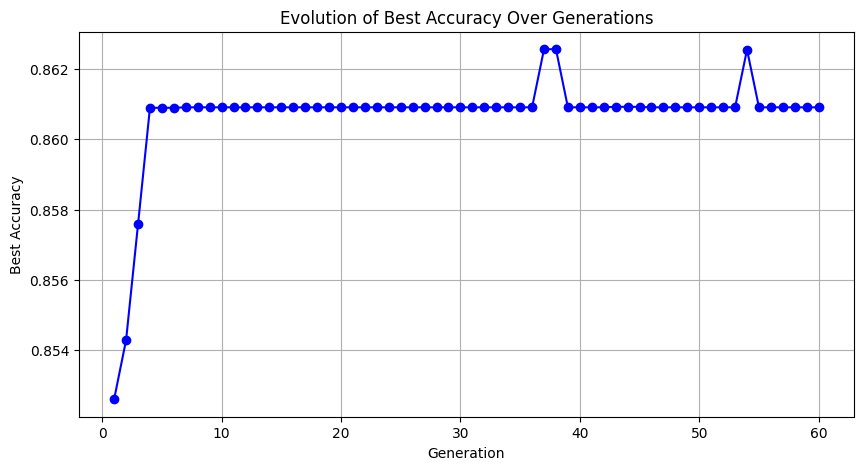

In [ ]:
# Plot best accuracy per generation
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_generations + 1), best_accuracies, marker='o', linestyle='-', color='blue')
plt.xlabel("Generation")
plt.ylabel("Best Accuracy")
plt.title("Evolution of Best Accuracy Over Generations")
plt.grid()
plt.show()


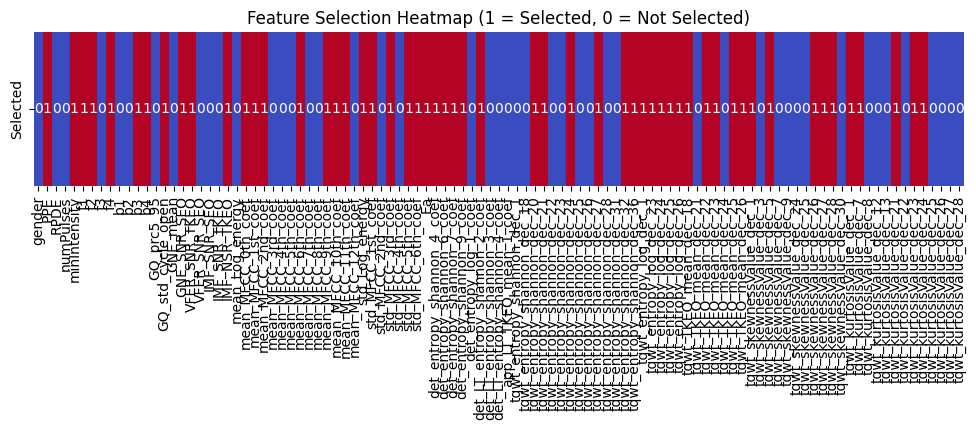

In [ ]:
# Convert selected features into a binary selection mask
feature_mask = np.array(best_individual).reshape(1, -1)

# Create a heatmap to visualize selected features
plt.figure(figsize=(12, 2))
sns.heatmap(feature_mask, cmap="coolwarm", annot=True, xticklabels=feature_names, yticklabels=["Selected"], cbar=False)
plt.title("Feature Selection Heatmap (1 = Selected, 0 = Not Selected)")
plt.xticks(rotation=90)
plt.show()


<ipython-input-20-739d7bda38e5>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(np.array(feature_names)[sorted_idx], rotation=90)
<ipython-input-20-739d7bda38e5>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(np.array(selected_features)[sorted_idx], rotation=90)


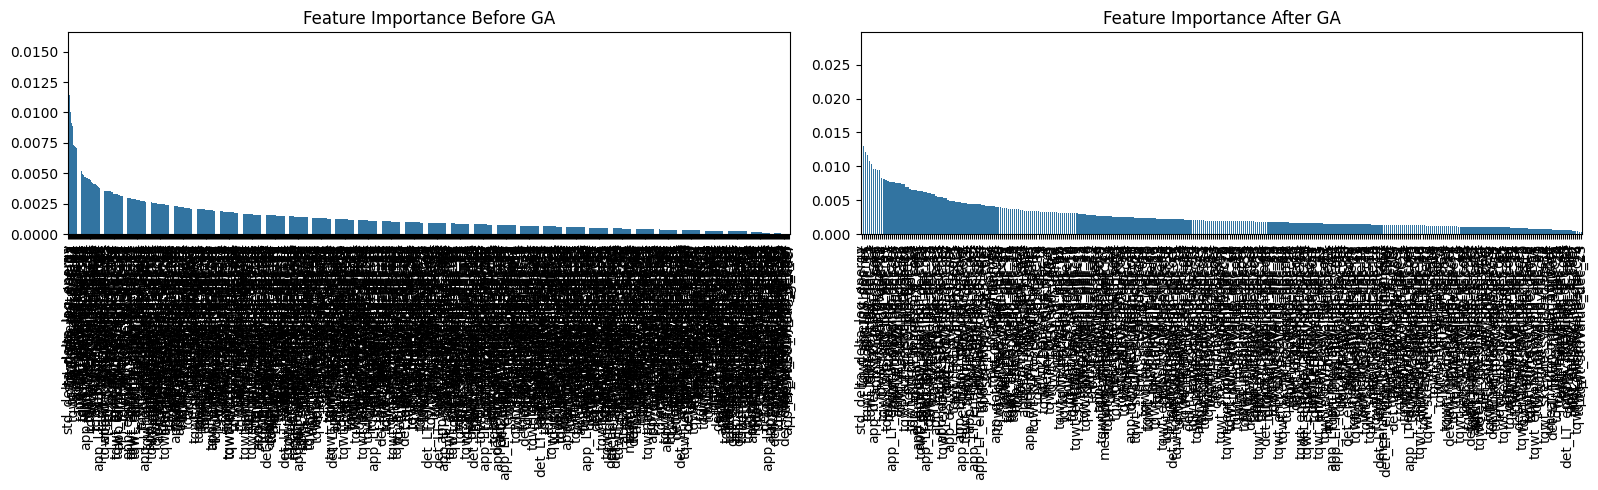

In [ ]:
# Train Random Forest with All Features
rf_all = RandomForestClassifier(random_state=42, n_estimators=100)
rf_all.fit(X_train, y_train)
feature_importances_all = rf_all.feature_importances_

# Train Random Forest with Selected Features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

rf_selected = RandomForestClassifier(random_state=42, n_estimators=100)
rf_selected.fit(X_train_selected, y_train)
feature_importances_selected = rf_selected.feature_importances_

# Plot Feature Importance Before vs After
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Before GA (All Features)
sorted_idx = np.argsort(feature_importances_all)[::-1]
sns.barplot(x=np.array(feature_names)[sorted_idx], y=feature_importances_all[sorted_idx], ax=axes[0])
axes[0].set_title("Feature Importance Before GA")
axes[0].set_xticklabels(np.array(feature_names)[sorted_idx], rotation=90)

# After GA (Selected Features)
sorted_idx = np.argsort(feature_importances_selected)[::-1]
sns.barplot(x=np.array(selected_features)[sorted_idx], y=feature_importances_selected[sorted_idx], ax=axes[1])
axes[1].set_title("Feature Importance After GA")
axes[1].set_xticklabels(np.array(selected_features)[sorted_idx], rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on test set
accuracy_selected = rf_selected.score(X_test_selected, y_test)
print("\n✅ Test Accuracy with Selected Features:", accuracy_selected)



✅ Test Accuracy with Selected Features: 0.8618421052631579


In [ ]:
# Save selected features
with open("selected_features.txt", "w") as f:
    for feature in selected_features:
        f.write(feature + "\n")

print("✅ Selected features saved to 'selected_features.txt'")

✅ Selected features saved to 'selected_features.txt'


'with open("ga_performance.txt", "w") as f:\n    f.write("Generation,Best_Accuracy\n")  # Header\n    for i, acc in enumerate(best_accuracies):\n        f.write(f"{i+1},{acc:.5f}\n")\n\nprint("✅ GA performance saved to \'ga_performance.txt\'")'

In [ ]:
search_space = {
    "n_estimators": (50, 500),
    "max_depth": (30, 100),  # 🔥 Increased depth for better feature interactions
    "min_samples_split": (2, 20),
    "min_samples_leaf": (1, 10),
    "max_features": (0.05, 0.3),  # 🔥 Lower fraction to prevent overfitting
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

In [ ]:
X_train_selected_np = X_train_selected.to_numpy()
y_train_np = y_train.to_numpy()

In [ ]:
# ✅ Initialize GPU-based Random Forest
rf_gpu = rfc_gpu()

# ✅ Bayesian Optimization with GPU
opt = BayesSearchCV(rf_gpu, search_space, n_iter=30, cv=5, scoring="accuracy", n_jobs=-1, random_state=42)

# ✅ Fit the model
opt.fit(X_train_selected_np, y_train_np)

# ✅ Print best parameters
print("✅ Best Hyperparameters:", opt.best_params_)
print("🔥 Best Accuracy:", opt.best_score_)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


✅ Best Hyperparameters: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 30), ('max_features', 0.1855432075998692), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])
🔥 Best Accuracy: 0.8973140495867767


In [ ]:
best_params = opt.best_params_  # Extract best hyperparameters

# Train Random Forest with best parameters
rf_best = rfc_gpu(**best_params)
rf_best.fit(X_train_selected, y_train)

# Predict on test set
y_pred = rf_best.predict(X_test_selected)

In [ ]:
# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.868421052631579
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.66      0.71        38
           1       0.89      0.94      0.91       114

    accuracy                           0.87       152
   macro avg       0.84      0.80      0.81       152
weighted avg       0.86      0.87      0.86       152



In [ ]:
rf2 = RandomForestClassifier(random_state=42, n_estimators=100)
rf2.fit(X_train, y_train)
# Predict on test set without optimization
y_pred2 = rf_best.predict(X_test_selected)
# Print accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred2))
print("Classification Report:\n", classification_report(y_test, y_pred2))

Accuracy: 0.868421052631579
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.66      0.71        38
           1       0.89      0.94      0.91       114

    accuracy                           0.87       152
   macro avg       0.84      0.80      0.81       152
weighted avg       0.86      0.87      0.86       152



#**Parkinson Dataset 3**

In [ ]:
df = pd.read_csv("/content/Parkinson2.csv")
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis,DoctorInCharge
0,3058,85,0,3,1,19.619878,0,5.108241,1.380660,3.893969,...,1.572427,1,0,0,0,0,0,0,0,DrXXXConfid
1,3059,75,0,0,2,16.247339,1,6.027648,8.409804,8.513428,...,4.787551,0,1,0,1,0,1,0,1,DrXXXConfid
2,3060,70,1,0,0,15.368239,0,2.242135,0.213275,6.498805,...,2.130686,1,0,0,0,1,0,1,1,DrXXXConfid
3,3061,52,0,0,0,15.454557,0,5.997788,1.375045,6.715033,...,3.391288,1,1,1,0,0,0,1,1,DrXXXConfid
4,3062,87,0,0,1,18.616042,0,9.775243,1.188607,4.657572,...,3.200969,0,0,0,1,0,1,0,0,DrXXXConfid


In [ ]:
df = pd.read_csv("/content/Parkinson1.csv")
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1.0,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1.0,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1.0,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1.0,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1.0,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [ ]:
df.status.unique()

array([1.        , 0.        , 0.87756117, ..., 0.77190708, 0.70431521,
       0.73538733])

#**Clustering Probability**

In [ ]:
import pandas as pd
import numpy as np

# Load dataset
#url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
data = pd.read_csv("/content/Parkinson1.csv")

In [ ]:
# Define conversion function
def categorize_status(value):
    if value == 0:
        return 0  # Healthy
    elif value == 1:
        return 1  # Parkinson’s
    else:
        return 3  # Mid-Range Category
    return -1  # Undefined (should not happen)

# Apply conversion
data['status_nominal'] = data['status'].apply(categorize_status)

# Verify conversion
print(data[['status', 'status_nominal']])

        status  status_nominal
0     1.000000               1
1     1.000000               1
2     1.000000               1
3     1.000000               1
4     1.000000               1
...        ...             ...
1190  0.736271               3
1191  0.798377               3
1192  0.771907               3
1193  0.704315               3
1194  0.735387               3

[1195 rows x 2 columns]


In [ ]:
data

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE,status_nominal
0,phon_R01_S01_1,119.992000,157.302000,74.997000,0.007840,0.000070,0.003700,0.005540,0.011090,0.043740,...,0.022110,21.033000,1.000000,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,phon_R01_S01_2,122.400000,148.650000,113.819000,0.009680,0.000080,0.004650,0.006960,0.013940,0.061340,...,0.019290,19.085000,1.000000,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,phon_R01_S01_3,116.682000,131.111000,111.555000,0.010500,0.000090,0.005440,0.007810,0.016330,0.052330,...,0.013090,20.651000,1.000000,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,phon_R01_S01_4,116.676000,137.871000,111.366000,0.009970,0.000090,0.005020,0.006980,0.015050,0.054920,...,0.013530,20.644000,1.000000,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,phon_R01_S01_5,116.014000,141.781000,110.655000,0.012840,0.000110,0.006550,0.009080,0.019660,0.064250,...,0.017670,19.649000,1.000000,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,synth_7756,151.028206,179.206312,118.797466,0.006594,0.000040,0.003458,0.003513,0.008731,0.027186,...,0.021377,21.884979,0.736271,0.499528,0.727604,-5.772439,0.234236,2.392305,0.210778,3
1191,synth_5355,161.752472,211.299774,114.784598,0.006397,0.000045,0.003545,0.003017,0.009591,0.028982,...,0.020925,21.973752,0.798377,0.499209,0.728558,-5.604039,0.235680,2.362850,0.209570,3
1192,synth_6356,148.323186,194.399282,118.570170,0.006335,0.000044,0.003483,0.003386,0.008980,0.029598,...,0.021530,21.615298,0.771907,0.497459,0.717687,-5.770640,0.233789,2.410545,0.223595,3
1193,synth_7098,152.106305,209.880095,112.903699,0.005298,0.000041,0.002778,0.003506,0.009388,0.029550,...,0.026806,21.561977,0.704315,0.486495,0.722529,-5.677169,0.236918,2.427505,0.218734,3


#**Dataset 2 - Only applied WSA and ACO**

In [ ]:
# Initialize WSA
wsa_selector = WolfSearchFeatureSelector(X_train, y_train, feature_names)
best_features_wsa = wsa_selector.run()

# Initialize ACO
aco_selector = AntColonyFeatureSelector(X_train, y_train, feature_names)
best_features_aco = aco_selector.run()


Best Feature Set Found (WSA): ['PPE', 'RPDE', 'numPulses', 'stdDevPeriodPulses', 'ppq5Jitter', 'ddpJitter', 'locShimmer', 'apq5Shimmer', 'apq11Shimmer', 'minIntensity', 'meanIntensity', 'f4', 'b1', 'b2', 'b3', 'b4', 'GQ_std_cycle_open', 'GQ_std_cycle_closed', 'GNE_mean', 'GNE_SNR_TKEO', 'GNE_SNR_SEO', 'GNE_NSR_TKEO', 'GNE_NSR_SEO', 'VFER_std', 'VFER_SNR_TKEO', 'IMF_SNR_SEO', 'IMF_SNR_TKEO', 'IMF_SNR_entropy', 'IMF_NSR_entropy', 'mean_Log_energy', 'mean_MFCC_1st_coef', 'mean_MFCC_2nd_coef', 'mean_MFCC_3rd_coef', 'mean_MFCC_4th_coef', 'mean_MFCC_7th_coef', 'mean_MFCC_8th_coef', 'mean_MFCC_10th_coef', 'mean_2nd_delta', 'mean_3rd_delta', 'mean_5th_delta', 'mean_7th_delta', 'mean_9th_delta', 'mean_10th_delta', 'mean_12th_delta', 'mean_delta_delta_0th', 'mean_8th_delta_delta', 'mean_9th_delta_delta', 'mean_11th_delta_delta', 'mean_12th_delta_delta', 'std_Log_energy', 'std_MFCC_1st_coef', 'std_MFCC_2nd_coef', 'std_MFCC_3rd_coef', 'std_MFCC_4th_coef', 'std_MFCC_6th_coef', 'std_MFCC_8th_coef', 

In [ ]:
X_train_wsa = X_train[best_features_wsa]
X_test_wsa = X_test[best_features_wsa]

# Train model using best hyperparameters
rf_wsa = RandomForestClassifier(**best_params)
rf_wsa.fit(X_train_wsa, y_train)

# Predict on WSA-selected features
y_pred_wsa = rf_wsa.predict(X_test_wsa)

# Evaluate WSA performance
print("🔹 WSA Feature Selection Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_wsa))
print("Classification Report:\n", classification_report(y_test, y_pred_wsa))


🔹 WSA Feature Selection Results:
Accuracy: 0.881578947368421
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.66      0.74        38
           1       0.89      0.96      0.92       114

    accuracy                           0.88       152
   macro avg       0.86      0.81      0.83       152
weighted avg       0.88      0.88      0.88       152



In [ ]:
X_train_aco = X_train[best_features_aco]
X_test_aco = X_test[best_features_aco]

# Train model using best hyperparameters
rf_aco = RandomForestClassifier(**best_params)
rf_aco.fit(X_train_aco, y_train)

# Predict on ACO-selected features
y_pred_aco = rf_aco.predict(X_test_aco)

# Evaluate ACO performance
print("🔹 ACO Feature Selection Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_aco))
print("Classification Report:\n", classification_report(y_test, y_pred_aco))


🔹 ACO Feature Selection Results:
Accuracy: 0.9013157894736842
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78        38
           1       0.91      0.96      0.94       114

    accuracy                           0.90       152
   macro avg       0.89      0.84      0.86       152
weighted avg       0.90      0.90      0.90       152



In [ ]:
results_df = pd.DataFrame({
    "Feature Selection": ["Original", "WSA", "ACO"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),   # Original features
        accuracy_score(y_test, y_pred_wsa),  # WSA
        accuracy_score(y_test, y_pred_aco)   # ACO
    ]
})

print(results_df)

  Feature Selection  Accuracy
0          Original  0.868421
1               WSA  0.881579
2               ACO  0.901316
